## Setup

### Importing Dependencies

In [1]:
# Data Loading
from datasets import load_dataset

# Torch for training models
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR

# Mathematical libraries
import numpy as np
import math
import cmath
from scipy import stats
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD
from sklearn.utils import check_array
from sklearn.cluster import MiniBatchKMeans
import dcor

# Visualization and data saving
from tqdm import tqdm, trange
import os
import matplotlib.pyplot as plt
import umap
import pickle

# Utilities
import random

### Fixing Random Seed for Reproducibility

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

### Setting the Project Directory

In [3]:
proj_dir = "QLens/" # Personalize if needed

## Loading Pre-Trained One Transformer Block Tiny Stories Model

In [4]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("roneneldan/TinyStories-1Layer-21M")
model = AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-1Layer-21M")

In [5]:
# Adding pad token to assist with batching later
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.pad_token = '[PAD]'

# Resizing token embeddings accordingly
model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(50258, 1024)

## Loading Data and Preparing Dataset

In [6]:
# Loading spliced and tokenized inputs
with open(f'{proj_dir}tokenized_inputs.pkl', 'rb') as f:
    tokenized_inputs = pickle.load(f)

In [7]:
class StoriesDataset(Dataset):
    def __init__(self, tokenized_inputs):
        # tokenized_inputs is a list of input token ids and attention masks
        self.tokenized_inputs = tokenized_inputs

    def __len__(self):
        return len(self.tokenized_inputs)

    def __getitem__(self, idx):
        return self.tokenized_inputs[idx]

"""
collate_fn() prepares batches for processing by padding them

Args:
    batch (List of dict with input_ids and attention_mask): Input batch to pad

Returns:
    padded_batch (LongTensor): Padded batch
"""
def collate_fn(batch):
    decoded_seqs = []

    for tok_seq in batch:
        text = tokenizer.decode(*tok_seq['input_ids'])
        decoded_seqs.append(text)

    padded = tokenizer(decoded_seqs, return_tensors = 'pt', padding = True)

    return padded

In [8]:
train_test_ratio = 0.75
cutoff = int(train_test_ratio * len(tokenized_inputs))

train_inputs = tokenized_inputs[:cutoff]
test_inputs = tokenized_inputs[cutoff:]

In [9]:
train_set = StoriesDataset(train_inputs)
test_set = StoriesDataset(test_inputs)

## Loading Pretrained Tuned Lens

### Submodel and Tuned Lens Classes

In [ ]:
class AttentionModel(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.embeddings = original_model.transformer.wte
        self.position_embeddings = original_model.transformer.wpe
        self.ln_1 = original_model.transformer.h[0].ln_1
        self.attention = original_model.transformer.h[0].attn

    def forward(self, input_ids, key_padding_mask):
        # Getting token and position embeddings
        pos_ids = torch.arange(0, input_ids.size(1), device=input_ids.device).unsqueeze(0)
        embedding_out = self.embeddings(input_ids) + self.position_embeddings(pos_ids)
        normalized_embeds = self.ln_1(embedding_out)

        # Forward pass through the first attention layer, causal mask is implemented internally
        atten_out = self.attention(normalized_embeds, attention_mask = key_padding_mask.unsqueeze(1).unsqueeze(2))[0] # returns (hidden_states, attn_weights)
        hidden_states = embedding_out + atten_out

        return hidden_states

class EmbeddingModel(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.embeddings = original_model.transformer.wte
        self.position_embeddings = original_model.transformer.wpe

    def forward(self, input_ids, use_pos_embeds = True):

        if use_pos_embeds:
            # Preparing position IDs if needed
            pos_ids = torch.arange(0, input_ids.size(1), device=input_ids.device).unsqueeze(0)
            embedding_out = self.embeddings(input_ids) + self.position_embeddings(pos_ids)
        else:
            embedding_out = self.embeddings(input_ids)

        return embedding_out

In [11]:
class TunedLens(nn.Module):
    def __init__(self, d_model, last_norm, unembedding_layer, name, bias_only = True):
        super(TunedLens, self).__init__()
        self.bias = nn.Parameter(torch.zeros(d_model))  # shape (d_model,)
        self.layer_norm = last_norm
        self.unembedding = unembedding_layer
        self.name = name

        self.bias_only = bias_only
        # If not a bias only, a learnable weight matrix is also needed
        if not bias_only:
            self.weight_mat = nn.Parameter(torch.zeros(d_model, d_model))

        # freezing layer_norm and unembedding
        for param in self.layer_norm.parameters():
            param.requires_grad = False
        for param in self.unembedding.parameters():
            param.requires_grad = False

    def forward(self, x):
        """
        x: (B, S, d_model)
        adds bias and returns logits: (B, S, V)
        broadcasting of bias over batch and seq dims works via PyTorch broadcasting
        """

        if self.bias_only:
            z = x + self.bias  # broadcasts over last dim
        else:
            z = (x @ self.weight_mat) + self.bias

        z = self.layer_norm(z)
        logits = self.unembedding(z)  # (B, S, vocab_size)

        return logits

    def train_model(self,
                    train_dataloader,
                    criterion,
                    optimizer,
                    num_epochs,
                    device,
                    proj_dir,
                    sub_model,
                    final_model,
                    pad_token_id,
                    scheduler=None):
        """
        Trains the TunedLens.

        - train_dataloader yields batches of token ids -> shape (B, S)
        - sub_model and final_model are passed in and used in eval mode under no_grad()
        - scheduler may be per-batch (e.g., OneCycleLR) or per-epoch; this function
          automatically handles both. It prints the LR after each epoch.
        """
        self.to(device)
        train_losses = []

        # detect per-batch scheduler (OneCycleLR or _get_lr_called_within_step)
        per_batch_scheduler = scheduler is not None and hasattr(scheduler, "step") and getattr(scheduler, "_step_count", None) is not None and isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR)

        # ensure teacher models are on device and in eval
        sub_model.to(device)
        final_model.to(device)
        sub_model.eval()
        final_model.eval()

        if isinstance(sub_model, EmbeddingModel):
            sub_model_type = 'embedding'
        else:
            sub_model_type = 'attention'

        print("Starting TunedLens training loop...")

        for epoch in range(1, num_epochs + 1):
            self.train()
            epoch_loss = 0.0
            n_batches = 0

            for batch_inputs in tqdm(train_dataloader, desc=f"Epoch {epoch}/{num_epochs}"):
                # batch_tokens: LongTensor (B, S) on CPU or pinned memory; move to device
                batch_tokens = batch_inputs['input_ids'].to(device)
                batch_mask = batch_inputs['attention_mask'].to(device)

                # Preparing inputs and labels
                pad_mask = (batch_tokens != pad_token_id) # (B, S_total)
                lengths = pad_mask.sum(dim=1) # (B,) representing valid sequence lengths

                # All but last token of each sequence is inputted into models
                input_tokens = torch.zeros([batch_tokens.shape[0], batch_tokens.shape[1] - 1]).to(device)
                input_mask = torch.zeros([batch_mask.shape[0], batch_mask.shape[1] - 1]).to(device)
                for i in range(batch_tokens.shape[0]):
                    L = int(lengths[i].item())
                    input_tokens[i, :] = torch.cat((batch_tokens[i, : L - 1], batch_tokens[i, L:]))
                    input_mask[i, :] = torch.cat((batch_mask[i, :L - 1], batch_mask[i, L:]))

                input_tokens = input_tokens.to(torch.long) # Ensuring d-type alignment
                input_mask = input_mask.to(torch.long)

                # compute mask of non-pad tokens (True = valid)
                loss_pad_mask = (input_tokens != pad_token_id)  # (B, S)

                # compute teacher signals in no_grad
                with torch.no_grad():
                    if sub_model_type == 'embedding':
                        residual = sub_model(input_tokens) # shape: (B, S, d_model)
                    else:
                        residual = sub_model(input_tokens, input_mask)

                    final_logits = final_model(input_ids = input_tokens, attention_mask = input_mask)['logits'] # shape: (B, S, vocab)

                # forward lens (student)
                student_logits = self(residual)  # (B, S, vocab)

                # compute masked KL loss
                loss = criterion(final_logits.float(), student_logits, pad_mask=loss_pad_mask)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # if scheduler is per-batch (e.g., OneCycleLR) step every batch
                if scheduler is not None and per_batch_scheduler:
                    scheduler.step()

                epoch_loss += loss.item()
                n_batches += 1

            avg_epoch_loss = epoch_loss / max(1, n_batches)
            train_losses.append(avg_epoch_loss)

            # step epoch-based schedulers here
            if scheduler is not None and not per_batch_scheduler:
                try:
                    scheduler.step()
                except Exception:
                    # Some schedulers require a metric; we do not call those automatically
                    pass

            # print learning rate
            if scheduler is not None and hasattr(scheduler, "get_last_lr"):
                current_lr = float(scheduler.get_last_lr()[0])
            else:
                current_lr = float(optimizer.param_groups[0]['lr'])

            print(f"Epoch [{epoch}/{num_epochs}]  Avg Loss: {avg_epoch_loss:.6f}  LR: {current_lr:.6g}")

            # optional: small quick eval on train subset or val set can be triggered here

        # Save checkpoint
        checkpoint = {
            'epoch': num_epochs,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_epoch_loss,
        }
        if scheduler is not None:
            try:
                checkpoint['scheduler_state_dict'] = scheduler.state_dict()
            except Exception:
                pass

        torch.save(checkpoint, proj_dir + self.name + '_lens_checkpoint.pth')
        print(f"Checkpoint for Epoch {num_epochs} saved to {proj_dir + self.name + '_lens_checkpoint.pth'}")

        # Plot loss curve
        plt.figure()
        plt.plot(np.arange(1, num_epochs + 1), np.array(train_losses), "-o")
        plt.grid(True)
        plt.xlabel("Epoch Number")
        plt.ylabel("Loss")
        plt.title(f"{self.name} Lens Loss")
        plt.savefig(proj_dir + self.name + "_lens_training_loss.png")
        plt.show()

        return train_losses

    def evaluate_model(self, test_dataloader, criterion, device, sub_model=None, final_model=None, pad_token_id=None):
        """
        Evaluate the TunedLens on batched test data.

        Returns avg loss and accuracy (agreement with teacher's top prediction).
        """
        self.to(device)
        self.eval()
        if sub_model is not None:
            sub_model.to(device)
            sub_model.eval()
        if final_model is not None:
            final_model.to(device)
            final_model.eval()

        total_loss = 0.0
        total_valid = 0
        total_matches = 0

        if isinstance(sub_model, EmbeddingModel):
            sub_model_type = 'embedding'
        else:
            sub_model_type = 'attention'

        with torch.no_grad():
            for batch_inputs in tqdm(test_dataloader, desc=f"Eval {self.name} lens"):
                batch_tokens = batch_inputs['input_ids'].to(device) # (B, S)
                batch_mask = batch_inputs['attention_mask'].to(device) # (B, S)

                # Preparing inputs and labels
                pad_mask = (batch_tokens != pad_token_id) # (B, S_total)
                lengths = pad_mask.sum(dim=1) # (B,) representing valid sequence lengths

                # All but last token of each sequence is inputted into models
                input_tokens = torch.zeros([batch_tokens.shape[0], batch_tokens.shape[1] - 1]).to(device)
                input_mask = torch.zeros([batch_mask.shape[0], batch_mask.shape[1] - 1]).to(device)
                for i in range(batch_tokens.shape[0]):
                    L = int(lengths[i].item())
                    input_tokens[i, :] = torch.cat((batch_tokens[i, :L - 1], batch_tokens[i, L:]))
                    input_mask[i, :] = torch.cat((batch_mask[i, :L - 1], batch_mask[i, L:]))

                input_tokens = input_tokens.to(torch.long) # Ensuring d-type alignment
                input_mask = input_mask.to(torch.long)

                loss_pad_mask = (input_tokens != pad_token_id)

                # Obtaining residual from submodel
                if sub_model_type == 'embedding':
                    residual = sub_model(input_tokens) # shape: (B, S, d_model)
                else:
                    residual = sub_model(input_tokens, input_mask)

                teacher_logits = final_model(input_ids = input_tokens, attention_mask = input_mask)['logits'] # (B, S, V)
                student_logits = self(residual) # (B, S, V)

                # compute loss
                batch_loss = criterion(teacher_logits.float(), student_logits, pad_mask=loss_pad_mask)
                total_loss += batch_loss.item() * batch_tokens.size(0)  # weight by batch-size for averaging

                # Teacher logits for last valid position
                teacher_last = torch.zeros([teacher_logits.shape[0], 1, teacher_logits.shape[2]]).to(device)
                for i in range(teacher_logits.shape[0]):
                    L = int(lengths[i].item())
                    teacher_last[i, :, :] = teacher_logits[i, L - 2, :]
                teacher_last = teacher_last.squeeze(1)

                # Student logits for last valid position
                student_last = torch.zeros([student_logits.shape[0], 1, student_logits.shape[2]]).to(device)
                for i in range(student_logits.shape[0]):
                    L = int(lengths[i].item())
                    student_last[i, :, :] = student_logits[i, L - 2, :]
                student_last = student_last.squeeze(1)

                # Computing accuracy of top-1 on last position against teacher's top-1
                teacher_last_tok = teacher_last.argmax(dim=-1) # (B,)
                student_last_tok = student_last.argmax(dim=-1) # (B,)

                total_matches += (teacher_last_tok == student_last_tok).sum().item()
                total_valid += batch_tokens.size(0)

        avg_loss = total_loss / max(1, total_valid)
        accuracy = total_matches / max(1, total_valid)

        print(f"\nEval {self.name} Lens - Avg loss: {avg_loss:.6f}, Accuracy vs teacher (last pos): {accuracy:.4f}")
        return {"avg_val_loss": avg_loss, "accuracy": accuracy}

In [12]:
"""
kl_loss() computes the Kullback-Leibler (KL) divergence loss between
two sets of logits in accordance with the original Tuned Lens paper.

Args:
    base_logits (torch.Tensor): The logits from the base Transformer.
    lens_logits (torch.Tensor): The logits from the Tuned Lens model.

Returns:
    torch.Tensor: The mean KL divergence loss over the batch.
"""
def kl_loss_teacher_student(teacher_logits, student_logits, pad_mask=None):
    """
    Mask-aware KL divergence averaged over valid tokens.
    teacher_logits, student_logits: (B, S, V)
    pad_mask: (B, S) boolean where True = valid token; if None, all tokens valid.
    Returns scalar: mean KL over valid tokens.
    """
    # compute log-probabilities
    log_p = nn.functional.log_softmax(teacher_logits, dim=-1)   # log P (teacher)
    log_q = nn.functional.log_softmax(student_logits, dim=-1)   # log Q (student)
    p = torch.exp(log_p)  # P

    # per-token KL: sum over vocab dimension -> shape (B, S)
    per_token_kl = torch.sum(p * (log_p - log_q), dim=-1)

    if pad_mask is None:
        return per_token_kl.mean()
    else:
        # mask: True where valid
        mask = pad_mask.to(per_token_kl.device).float()
        total_valid = mask.sum()
        if total_valid.item() == 0:
            # no valid tokens: avoid divide-by-zero
            return torch.tensor(0.0, device=per_token_kl.device, requires_grad=True)
        masked_sum = (per_token_kl * mask).sum()
        return masked_sum / total_valid

### Embedding  Lens

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pad_idx = tokenizer.pad_token_id
d_model = model.transformer.wte.weight.shape[1]

# Embedding model
embedding_model = EmbeddingModel(model).to(device)

# Instantiating embedding lens
embedding_lens = TunedLens(d_model = d_model,
                           last_norm = model.transformer.ln_f,
                           unembedding_layer = model.lm_head,
                           name='embedding',
                           bias_only = False).to(device)

In [14]:
# Loading embedding lens checkpoint
embedding_lens_checkpoint_file = "embedding_lens_checkpoint.pth"
embedding_lens_checkpoint = torch.load(os.path.join(proj_dir, embedding_lens_checkpoint_file))

# Loading embedding lens state dict
embedding_lens_state_dict = embedding_lens_checkpoint["model_state_dict"]
embedding_lens.load_state_dict(embedding_lens_state_dict)

<All keys matched successfully>

### Attention Lens

In [15]:
# Attention model
attention_model = AttentionModel(model).to(device)

# Instantiating the attention lens
attention_lens = TunedLens(d_model = d_model,
                           last_norm = model.transformer.ln_f,
                           unembedding_layer = model.lm_head,
                           name='attention',
                           bias_only = False).to(device)

In [16]:
# Loading embedding lens checkpoint
attention_lens_checkpoint_file = "attention_lens_checkpoint.pth"
attention_lens_checkpoint = torch.load(os.path.join(proj_dir, attention_lens_checkpoint_file))

# Loading embedding lens state dict
attention_lens_state_dict = attention_lens_checkpoint["model_state_dict"]
attention_lens.load_state_dict(attention_lens_state_dict)

<All keys matched successfully>

## Analyzing the Householder Reflection Vectors of Unitary Operators

### Computing the Householder Reflection Vectors

In [ ]:
def get_logits_for_position(batch_tokens, input_mask, pos, device,
                            embedding_model, attention_model,
                            embedding_lens, attention_lens, model):
    """
    Return logits (B, S, V) for requested position:
      pos == 'embedding'  -> embedding_lens(embedding_model(batch_tokens))
      pos == 'attention'  -> attention_lens(attention_model(batch_tokens))
      pos == 'final'      -> model(batch_tokens, return_probs=False)
    All returned tensors are floats on device (not softmaxed yet).
    """

    if pos == 'embedding':
        # embedding_model -> (B,S,d_model); embedding_lens -> logits (B,S,V)
        residual = embedding_model(batch_tokens)      # ensure embedding_model handles batch on device
        logits = embedding_lens(residual)             # logits (B,S,V)
    elif pos == 'attention':
        residual = attention_model(batch_tokens, input_mask)
        logits = attention_lens(residual)
    elif pos == 'final':
        # The transformer model's forward with return_probs=False returns logits shape (B,S,V)
        logits = model(input_ids = batch_tokens, attention_mask = input_mask)['logits']
    else:
        raise ValueError("pos must be 'embedding', 'attention', or 'final'")

    return logits  # (B,S,V) on same device as model

def compute_last_idx_householder_vectors(
    dataset,
    batch_size=128,
    pos0='embedding',
    pos1='final',
    pad_idx=None,
    device=None,
    embedding_model=None,
    attention_model=None,
    embedding_lens=None,
    attention_lens=None,
    model=None,
    dtype=torch.float32,
    num_workers=4,
    pin_memory=True,
):
    """
    compute_last_idx_householder_vectors() derives the Householder normal vectors for the 
    last valid position in each input sequence while using batching.

    Args:
        dataset (StoriesDataset): Dataset to compute Householder vectors for.
        batch_size (int): batch size for DataLoader
        pos0, pos1 (str): Determines which submodel and embedding lenes to use,
                        each can be one of 'embedding,' 'attention,' or 'final'.
        pad_idx (int): pad token id
        device (torch.device): torch device (e.g., torch.device('cuda'))
        embedding_model, attention_model, embedding_lens, attention_lens, model: Lens and submodels to compute Householder vectors with
        dtype (torch.dtype): dtype for intermediate computations
    Returns:
        all_hh_vecs (list of np.ndarray): A Python list of numpy arrays, each of which is a Householder vector 
                                        derived from the corresponding instance in the dataset.
        all_ket0_vecs (list of np.ndarray): A Python list of numpy arrays, each of which is the input state ket
    """

    assert device is not None, "Provide device"
    assert pad_idx is not None, "Provide pad_idx"
    assert model is not None and embedding_model is not None and attention_model is not None, "Provide models"
    # choose which lenses are not None
    assert embedding_lens is not None and attention_lens is not None, "Provide both embedding_lens and attention_lens"

    loader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        collate_fn=collate_fn,
                        num_workers=num_workers,
                        pin_memory=pin_memory)

    # make sure the teacher and lenses are in eval and on device
    model.to(device).eval()
    embedding_model.to(device).eval()
    attention_model.to(device).eval()
    embedding_lens.to(device).eval()
    attention_lens.to(device).eval()

    all_hh_vecs = []  # will append per-batch per-sample lists
    all_ket0_vecs = []

    chunk_idx = 0
    saved_chunks = []

    with torch.no_grad():
        for batch_inputs in tqdm(loader, desc="HH batch"):
            # moving inputs to device
            batch_tokens = batch_inputs['input_ids'].to(device) # (B, S)
            batch_mask = batch_inputs['attention_mask'].to(device) # (B, S)

            # Preparing inputs
            pad_mask = (batch_tokens != pad_idx) # (B, S_total)
            lengths = pad_mask.sum(dim=1) # (B,) representing valid sequence lengths

            # All but last token of each sequence is inputted into models
            input_tokens = torch.zeros([batch_tokens.shape[0], batch_tokens.shape[1] - 1]).to(device)
            input_mask = torch.zeros([batch_mask.shape[0], batch_mask.shape[1] - 1]).to(device)
            for i in range(batch_tokens.shape[0]):
                for j in range(batch_tokens.shape[1]):
                    if j < lengths[i] - 1:
                        input_tokens[i, j] = batch_tokens[i, j]
                        input_mask[i, j] = batch_mask[i, j]
                    elif j > lengths[i] - 1:
                        input_tokens[i, j - 1] = batch_tokens[i, j]
                        input_mask[i, j - 1] = batch_mask[i, j]

            input_tokens = input_tokens.to(torch.long) # Ensuring d-type alignment
            input_mask = input_mask.to(torch.long) # Ensuring d-type alignment

            # compute logits for pos0 and pos1
            logits0 = get_logits_for_position(input_tokens, input_mask, pos0, device,
                                              embedding_model, attention_model,
                                              embedding_lens, attention_lens, model)
            logits1 = get_logits_for_position(input_tokens, input_mask, pos1, device,
                                              embedding_model, attention_model,
                                              embedding_lens, attention_lens, model)

            # Initial logits for last valid position in each sequence
            logits0_last = torch.zeros([logits0.shape[0], 1, logits0.shape[2]]).to(device)
            for i in range(logits0.shape[0]):
                logits0_last[i, :, :] = logits0[i, lengths[i] - 2, :]
            logits0_last = logits0_last.squeeze(1)

            # Final logits for last valid position in each sequence
            logits1_last = torch.zeros([logits1.shape[0], 1, logits1.shape[2]]).to(device)
            for i in range(logits1.shape[0]):
                logits1_last[i, :, :] = logits1[i, lengths[i] - 2, :]
            logits1_last = logits1_last.squeeze(1)

            # convert to probabilities in float (stable)
            probs0 = torch.softmax(logits0_last.to(dtype), dim=-1)  # (B, V)
            probs1 = torch.softmax(logits1_last.to(dtype), dim=-1)  # (B, V)

            # State vector construction
            ket0 = torch.sqrt(probs0.clamp(min=1e-30))
            ket1 = torch.sqrt(probs1.clamp(min=1e-30))

            # Householder extraction
            delta = ket1 - ket0
            norms = torch.linalg.norm(delta, dim=1, keepdim=True).clamp(min=1e-12)
            hh_flat = (delta / norms).cpu()  # (B, V)

            # Creating lists of Householder reflection vectors and input state kets
            hh_batch = []
            ket0_batch = []
            for i in range(hh_flat.shape[0]):
                hh_batch.append([hh_flat[i].cpu().numpy()])
                ket0_batch.append([ket0[i].cpu().numpy()])

            # hh_batch and ket0_batch are lists of length B of lists of numpy arrays
            all_hh_vecs.extend(hh_batch)
            all_ket0_vecs.extend(ket0_batch)


    return all_hh_vecs, all_ket0_vecs  # list-of-lists (len = dataset), each inner list contains one numpy array per interaction

In [18]:
# Dataset - sample of 5000 instances
rand_idxs = random.sample(range(len(test_set)), 5000)
test_set_5000 = [test_set[i] for i in rand_idxs]
unitary_dataset = StoriesDataset(test_set_5000)

In [19]:
attention_hh_vecs, attention_ket0_vecs = compute_last_idx_householder_vectors(
    unitary_dataset,
    batch_size=4,
    pos0='embedding',
    pos1='attention',
    pad_idx=pad_idx,
    device=device,
    embedding_model=embedding_model,
    attention_model=attention_model,
    embedding_lens=embedding_lens,
    attention_lens=attention_lens,
    model=model,
    dtype=torch.float32,
    num_workers=4,
    pin_memory=True,
)

HH batch: 100%|██████████| 1250/1250 [01:50<00:00, 11.30it/s]


In [20]:
mlp_hh_vecs, mlp_ket0_vecs = compute_last_idx_householder_vectors(
    unitary_dataset,
    batch_size=4,
    pos0='attention',
    pos1='final',
    pad_idx=pad_idx,
    device=device,
    embedding_model=embedding_model,
    attention_model=attention_model,
    embedding_lens=embedding_lens,
    attention_lens=attention_lens,
    model=model,
    dtype=torch.float32,
    num_workers=4,
    pin_memory=True,
)

HH batch: 100%|██████████| 1250/1250 [01:50<00:00, 11.27it/s]


In [21]:
# Saving embedding and attention Householder vectors

with open(f'{proj_dir}attention_hh_vecs.pickle', 'wb') as f:
    pickle.dump(attention_hh_vecs, f)

with open(f'{proj_dir}mlp_hh_vecs.pickle', 'wb') as f:
    pickle.dump(mlp_hh_vecs, f)

### PCA-Based Analysis

In [ ]:
def efficient_pca(
    vec_source,
    plt_title = 'PCA Plot',
    file_name = 'pca.png',
    create_scatter = True,
    proj_dir="./QLens/",
    n_components=2,
    method="auto",
    batch_size=10000,
    dtype=np.float32,
    plot_max_points=50000,
    random_state=42,
    svd_iter=5,
):
    """
    efficient_pca() Perform PCA (efficiently) and creates a scatter-plot of the 
    first two components, if specified.

    Args:
        vec_source: Input vectors to perform PCA onone of:
            - numpy array shape (N, D).
            - list of numpy arrays (list of 2D arrays or list-of-1D arrays).
            - path to .npz/.npz chunk files where each file has 'data' = object array of per-sample vectors.
        plt_title (str): Title of resulting plot.
        file_name (str): Filename for saving the plot.
        create_scatter (bool): Whether to create a scatter plot of the first two PCA components, defaults to True.
        proj_dir (str): Directory to save the plot.
        n_components (int): number of PCA components to compute, defaults to 2.
        method (str): Selects the PCA method to use, one of "auto", "randomized", "incremental", or "truncated".
        batch_size (int): Used for batching in IncrementalPCA or when reading chunks from disk.
        dtype (np.dtype): dtype to use in calculations, defaults to np.float32.
        plot_max_points (int): Maxinum number of points to plot before random subsample goes into effect.
        random_state (int): Random state for PCA and subsampling (if applicable).
        svd_iter (int): The number of iterations used for randomized SVD (if used).
    Returns:
        X_pca (N,2) numpy array of projected points, pca_object (fitted sklearn transformer)
    """

    # Helper function generates batches of 2D numpy arrays from various vec_source types
    def batch_generator_from_source(src, batch_size):
        # Handling an input numpy array
        if isinstance(src, np.ndarray):
            N = src.shape[0]
            for i in range(0, N, batch_size):
                yield src[i:i+batch_size].astype(dtype, copy=False)
            return

        # Handling a list-like structure of arrays
        if isinstance(src, (list, tuple)):
            # If list of 1D arrays, they are stacked in batches
            idx = 0
            while idx < len(src):
                block = src[idx:idx+batch_size]
                # Converting each array to 2D if needed
                block2 = []
                for v in block:
                    a = np.asarray(v, dtype=dtype)
                    if a.ndim == 1:
                        a = a.reshape(1, -1)
                    block2.append(a)
                yield np.vstack(block2)
                idx += batch_size
            return

        # Handling a path or glob of .npz chunk files
        if isinstance(src, str) and os.path.exists(src):
            # Detecting a single .npz file or directory prefix
            if os.path.isfile(src) and src.endswith(".npz"):
                npz_files = [src]
            elif os.path.isdir(src):
                # Getting .npz files inside
                npz_files = sorted([os.path.join(src, f) for f in os.listdir(src) if f.endswith(".npz")])
            else:
                raise ValueError("vec_source string must be a .npz file or directory containing .npz files")

            for fn in npz_files:
                data = np.load(fn, allow_pickle=True)["data"]
                # Iterating over data in batches
                arrs = [np.asarray(x, dtype=dtype).reshape(1, -1) if np.asarray(x).ndim==1 else np.asarray(x, dtype=dtype) for x in data]
                idx = 0
                while idx < len(arrs):
                    block = arrs[idx:idx+batch_size]
                    yield np.vstack(block)
                    idx += batch_size
            return

        raise ValueError("Unsupported vec_source type")

    # Deciding the PCA method automatically if requested
    # Trying to estimate N and D if possible
    est_N = None
    est_D = None
    if isinstance(vec_source, np.ndarray):
        est_N, est_D = vec_source.shape
    elif isinstance(vec_source, (list, tuple)) and len(vec_source) > 0:
        # Inspecting first element
        first = np.asarray(vec_source[0])
        est_D = first.shape[-1]
        est_N = sum(1 if np.asarray(x).ndim==1 else np.asarray(x).shape[0] for x in vec_source)
    elif isinstance(vec_source, str) and os.path.exists(vec_source):
        # Leaving method selection flexible
        pass

    if method == "auto":
        if est_N is not None and est_D is not None:
            # Heuristic determination of method: if data is huge either in N or D, incremental/truncated PCA is preferred
            if est_N * est_D > 5e8:
                method_use = "incremental"
            elif est_D > 5000:
                method_use = "truncated"
            else:
                method_use = "randomized"
        else:
            method_use = "incremental"
    else:
        method_use = method

    # Fitting PCA / SVD
    if method_use == "randomized":
        # Loading all data into memory once (fast if it fits)
        if isinstance(vec_source, np.ndarray):
            X = vec_source.astype(dtype, copy=False)
        else:
            # Collecting data in batches and stacking
            blocks = []
            for block in batch_generator_from_source(vec_source, batch_size):
                blocks.append(block)
            X = np.vstack(blocks).astype(dtype, copy=False)
        pca = PCA(n_components=n_components, svd_solver="randomized", random_state=random_state, iterated_power=svd_iter)
        X_pca = pca.fit_transform(X)
        explained = pca.explained_variance_ratio_ * 100.0

    elif method_use == "incremental":
        ipca = IncrementalPCA(n_components=n_components)
        # First pass performs a partial_fit while using batching
        for block in batch_generator_from_source(vec_source, batch_size):
            block = check_array(block, dtype=dtype, ensure_2d=True)
            ipca.partial_fit(block)
        # Second pass transforms to obtain components
        transformed_blocks = []
        for block in batch_generator_from_source(vec_source, batch_size):
            block = check_array(block, dtype=dtype, ensure_2d=True)
            transformed_blocks.append(ipca.transform(block))
        X_pca = np.vstack(transformed_blocks)
        pca = ipca
        # Obtianing the explained variance ratio if available
        explained = getattr(ipca, "explained_variance_ratio_", None)
        if explained is not None:
            explained = explained * 100.0
        else:
            explained = [np.nan] * n_components

    elif method_use == "truncated":
        tsvd = TruncatedSVD(n_components=n_components, random_state=random_state, n_iter=svd_iter)
        # Feeding in either dense or sparse batches to TruncatedSVD
        if isinstance(vec_source, np.ndarray):
            X = vec_source.astype(dtype, copy=False)
            X_pca = tsvd.fit_transform(X)
        else:
            blocks = []
            for block in batch_generator_from_source(vec_source, batch_size):
                blocks.append(block)
            X = np.vstack(blocks)
            X_pca = tsvd.fit_transform(X)
        pca = tsvd
        explained = getattr(tsvd, "explained_variance_ratio_", [np.nan] * n_components)
        explained = np.array(explained) * 100.0

    else:
        raise ValueError("Unknown method_use: " + str(method_use))

    # Creating scatter plot if specified
    if create_scatter:
        # Subsampling data points if a large number are present
        N = X_pca.shape[0]
        if N > plot_max_points:
            rng = np.random.default_rng(random_state)
            keep = rng.choice(N, size=plot_max_points, replace=False)
            plot_pts = X_pca[keep]
        else:
            plot_pts = X_pca

        plt.figure(figsize=(7,6))
        plt.scatter(plot_pts[:, 0], plot_pts[:, 1], alpha=0.7, s=6)

        # Axes labels include explained variance if available
        if explained is not None and len(explained) >= 2 and not np.isnan(explained[0]):
            plt.xlabel(f"PC1 ({explained[0]:.1f}% var)")
            plt.ylabel(f"PC2 ({explained[1]:.1f}% var)")
        else:
            plt.xlabel("PC1")
            plt.ylabel("PC2")

        plt.title(plt_title)
        plt.grid(alpha=0.25)
        plt.tight_layout()

        # Creating directory to save scatter plot at if necessary
        os.makedirs(proj_dir, exist_ok=True)
        outpath = os.path.join(proj_dir, file_name)
        plt.savefig(outpath)
        plt.show()

    return X_pca, pca

In [23]:
attention_hh_vecs_array = np.array(attention_hh_vecs).squeeze(axis = 1)

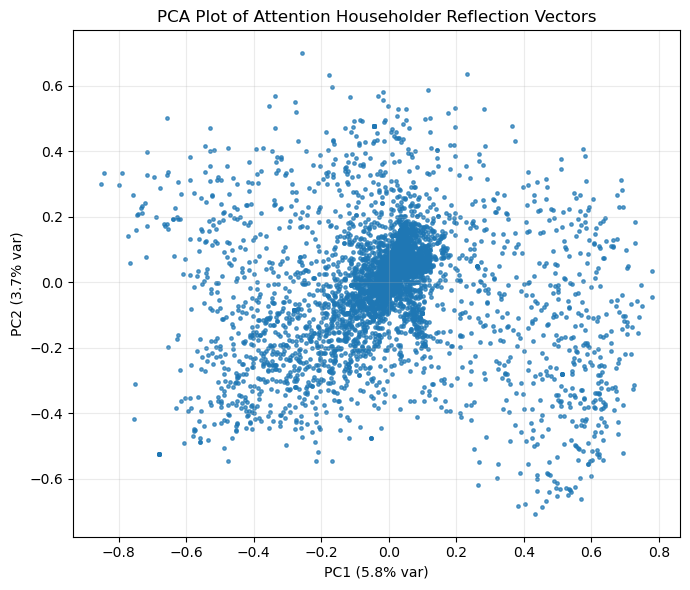

In [ ]:
attention_X_pca, attention_pca = efficient_pca(attention_hh_vecs_array,
                                                'PCA Plot of Attention Householder Reflection Vectors',
                                                'attention_hh_vecs_pca.png',
                                                proj_dir=proj_dir,
                                                method="randomized")

In [25]:
mlp_hh_vecs_array = np.array(mlp_hh_vecs).squeeze(axis = 1)

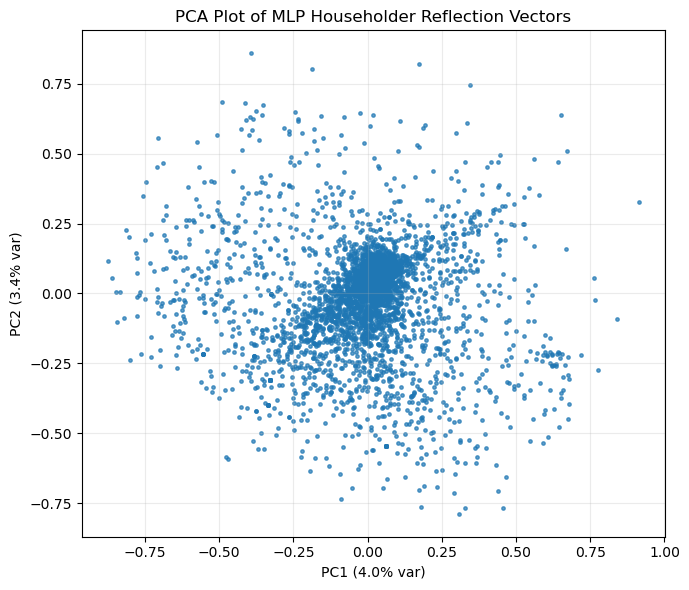

In [ ]:
mlp_X_pca, mlp_pca = efficient_pca(mlp_hh_vecs_array,
                                    'PCA Plot of MLP Householder Reflection Vectors',
                                    'mlp_hh_vecs_pca.png',
                                    proj_dir=proj_dir,
                                    method="randomized")

### Colored UMAP and Cluster Analysis

In [ ]:
def create_vec_scatter_umap(
    vec_source,
    plt_title,
    file_name,
    color_labels = None,
    proj_dir="./QLens/",
    n_components=2,
    batch_size=10000,
    dtype=np.float32,
    plot_max_points=20000,
    random_state=42,
    # UMAP-specific
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",  # e.g., "cosine" for embeddings
    init="spectral",
    sample_fit_max=200000,  # subsample size used to fit UMAP; rest is streamed via transform
    target_metric=None,     # optional supervised embedding
    target=None,            # labels if supervised
):
    """
    create_vec_scatter_umap() performs UMAP efficiently on large datasets 
    and creates a scatter-plot of the first two components.

    It employs the following three step process:
      1. Build UMAP on a representative subsample (up to sample_fit_max).
      2. Transforming the remaining datapoints in batches.
      3. Creating scatter plot, subsampling as necessary to keep visualization responsive.

    Args:
        vec_source: The high dimensional vectors to plot, one of
            - a numpy array of shape (N, D).
            - a list of numpy arrays (list of 2D arrays or list-of-1D arrays).
            - a path to .npz files where each has 'data' = object array of per-sample vectors.
        plt_title (str): Title of resulting plot.
        file_name (str): Filename for saving the plot.
        color_labels (array-like): Optional array of length N for coloring points by cluster labels.
        proj_dir (str): Directory to save the plot.
        n_components (int): Number of UMAP components to project to, defaults to 2.
        batch_size: Used when reading data chunks and for transform streaming.
        dtype (torch.dtype): dtype used in computations, defaults to float32.
        plot_max_points (int): Maxinum number of points to plot before random subsample goes into effect.
        random_state (int): The Random seed for UMAP and subsampling, defaults to 42.
        UMAP hyperparams: n_neighbors, min_dist, metric, init, target_metric, target.
        sample_fit_max (int): The maximum number of samples to fit UMAP on (the rest are transformed).

    Returns:
        X_umap (np.ndarray of N, n_components): A numpy array of projected points.
        umap_obj: Fitted UMAP object.
    """

    # Helper function generates 2D numpy arrays as batches
    def batch_generator_from_source(src, batch_size):
        # Handling numpy arrays
        if isinstance(src, np.ndarray):
            N = src.shape[0]
            for i in range(0, N, batch_size):
                yield src[i:i+batch_size].astype(dtype, copy=False)
            return

        # Handling a list-like structure of arrays
        if isinstance(src, (list, tuple)):
            idx = 0
            while idx < len(src):
                block = src[idx:idx+batch_size]
                block2 = []
                for v in block:
                    a = np.asarray(v, dtype=dtype)
                    if a.ndim == 1:
                        a = a.reshape(1, -1)
                    block2.append(a)
                yield np.vstack(block2)
                idx += batch_size
            return

        # Handling a file path or glob of .npz chunk files
        if isinstance(src, str) and os.path.exists(src):
            if os.path.isfile(src) and src.endswith(".npz"):
                npz_files = [src]
            elif os.path.isdir(src):
                npz_files = sorted([os.path.join(src, f) for f in os.listdir(src) if f.endswith(".npz")])
            else:
                raise ValueError("vec_source string must be a .npz file or directory containing .npz files")

            for fn in npz_files:
                data = np.load(fn, allow_pickle=True)["data"]
                arrs = [
                    np.asarray(x, dtype=dtype).reshape(1, -1) if np.asarray(x).ndim == 1
                    else np.asarray(x, dtype=dtype)
                    for x in data
                ]
                idx = 0
                while idx < len(arrs):
                    block = arrs[idx:idx+batch_size]
                    yield np.vstack(block)
                    idx += batch_size
            return

        raise ValueError("Unsupported vec_source type")

    # First pass gathers a subsample to fit on
    fit_blocks = []
    fit_count = 0
    for block in batch_generator_from_source(vec_source, batch_size):
        block = check_array(block, dtype=dtype, ensure_2d=True)
        remaining = sample_fit_max - fit_count
        if remaining <= 0:
            break
        if block.shape[0] <= remaining:
            fit_blocks.append(block)
            fit_count += block.shape[0]
        else:
            fit_blocks.append(block[:remaining])
            fit_count += remaining
            break

    if fit_count == 0:
        raise ValueError("No data found for fitting UMAP.")

    X_fit = np.vstack(fit_blocks)

    # Optional supervised setup
    y_fit = None
    if target is not None:
        if isinstance(vec_source, np.ndarray) and isinstance(target, np.ndarray):
            y_fit = target[:X_fit.shape[0]]
        else:
            y_fit = target

    # Fitting UMAP on a subsample
    umap_obj = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        init=init,
        random_state=random_state,
        transform_seed=random_state,
        target_metric=target_metric,
        verbose=False,
    )

    umap_obj.fit(X_fit, y=y_fit)

    # Second pass transforms all data
    transformed_blocks = []
    for block in batch_generator_from_source(vec_source, batch_size):
        block = check_array(block, dtype=dtype, ensure_2d=True)
        transformed = umap_obj.transform(block)
        transformed_blocks.append(transformed)

    X_umap = np.vstack(transformed_blocks)

    # Creating the UMAP plot, while subsampling if large number of data points are present
    N = X_umap.shape[0]
    if N > plot_max_points:
        rng = np.random.default_rng(random_state)
        keep = rng.choice(N, size=plot_max_points, replace=False)
        plot_pts = X_umap[keep]
    else:
        plot_pts = X_umap

    plt.figure(figsize=(7, 6))

    # Determining whether to use color labels
    if color_labels is None:
        plt.scatter(plot_pts[:, 0], plot_pts[:, 1], alpha=0.7, s=6)
    else:
        plt.scatter(plot_pts[:, 0], plot_pts[:, 1], c=color_labels, cmap='tab20', alpha=0.7, s=6)

    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.title(plt_title)
    plt.grid(alpha=0.25)
    plt.tight_layout()

    os.makedirs(proj_dir, exist_ok=True)
    outpath = os.path.join(proj_dir, file_name)
    plt.savefig(outpath)
    plt.show()

    return X_umap, umap_obj

In [28]:
pca_dims = 600
attention_hh_vecs_X_cluster_pca, attention_hh_vecs_cluster_pca = efficient_pca(attention_hh_vecs_array,
                                                                                create_scatter = False,
                                                                                method="randomized",
                                                                                n_components = pca_dims)

# Explained variance check
attention_hh_vecs_ex_var_ratio = attention_hh_vecs_cluster_pca.explained_variance_ratio_.sum()
print(f'Explained Variance ratio for {pca_dims} dimensions: {(attention_hh_vecs_ex_var_ratio * 100):.4f}%')

Explained Variance ratio for 600 dimensions: 91.1952%


In [34]:
def elbow_plot_analysis(data, plt_title, file_name, min_clusters = 5, max_clusters = 100, step = 1, random_state = 42):
    cluster_range = range(min_clusters, max_clusters + 1, step)

    inertia_values = []

    print(f"Starting MiniBatchKMeans fitting for number of clusters between {min_clusters} and {max_clusters}...")

    for n_clusters in tqdm(cluster_range, desc = 'Fitting clusters'):
        # Initializing MiniBatchKMeans with the current n_clusters
        kmeans = MiniBatchKMeans(
            n_clusters=n_clusters,
            random_state=random_state,
            n_init='auto',
            max_iter=30,
            verbose=0
        )

        # Fitting the model to the data
        kmeans.fit(data)

        # Appending the inertia to the list
        inertia_values.append(kmeans.inertia_)

    # Creating elbow plot
    plt.figure(figsize=(10, 6))

    # Plotting the inertia values
    plt.plot(cluster_range, inertia_values, marker='o', linestyle='-', color='blue')

    # Adding labels and title
    plt.xlabel('Number of Clusters', fontsize=14)
    plt.ylabel('Total Inertia', fontsize=14)
    plt.title(plt_title, fontsize=16)

    # Formating for readability
    plt.xticks(np.arange(min_clusters, max_clusters + 1, 10))
    plt.yticks(np.arange(min(inertia_values) - 1, max(inertia_values) + 1, 50))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Saving plot
    plt.savefig(os.path.join(proj_dir, file_name))

    # Displaying plot
    plt.show()

Starting MiniBatchKMeans fitting for number of clusters between 5 and 150...


Fitting clusters: 100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


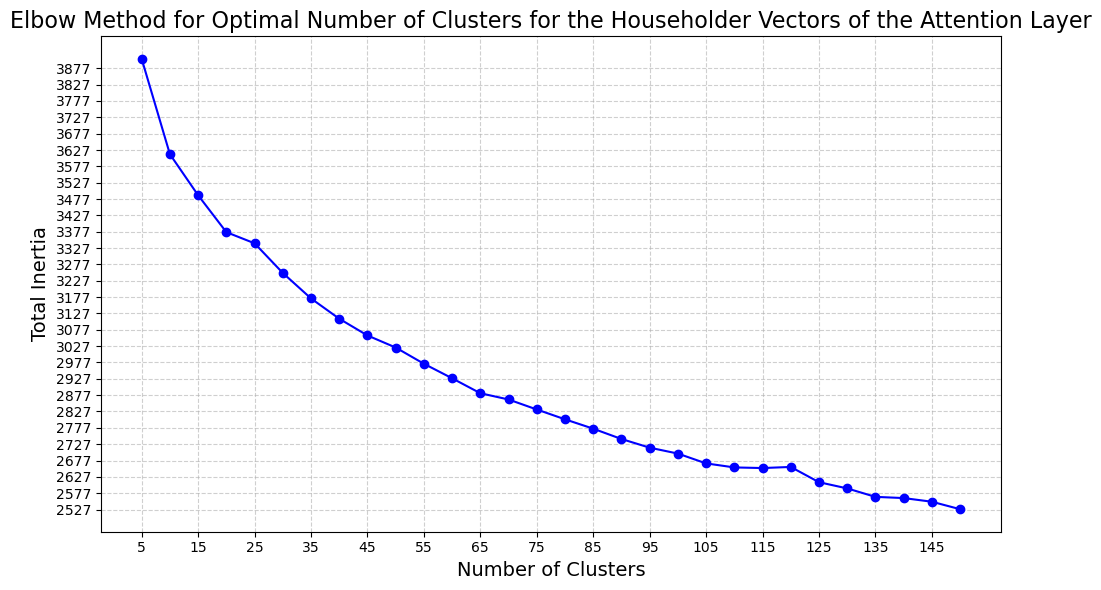

In [35]:
# Creating elbow plot for the Householder Vectors of the Attention Layer
elbow_plot_analysis(attention_hh_vecs_X_cluster_pca,
                    'Elbow Method for Optimal Number of Clusters for the Householder Vectors of the Attention Layer',
                    'elbow_attention_hh_vecs.png',
                   5, 150, 5)

In [36]:
attention_hh_vecs_X_cluster_pca = attention_hh_vecs_X_cluster_pca.astype('float64')

n_clusters_attention = 25
random_state_val = 42 # Set a random state for reproducibility

# Initializing MiniBatchKMeans
attention_hh_vecs_kmeans = MiniBatchKMeans(
    n_clusters=n_clusters_attention,
    random_state=random_state_val,
    n_init='auto',
    max_iter=30,
    verbose=1
)

# Training k-means model
attention_hh_vecs_kmeans.fit(attention_hh_vecs_X_cluster_pca)

# Assigning each point to cluster
attention_hh_vecs_color_labels = attention_hh_vecs_kmeans.predict(attention_hh_vecs_X_cluster_pca)

Init 1/1 with method k-means++
Inertia for init 1/1: 3345.499709683461
Minibatch step 1/146: mean batch inertia: 1.0829077507692424
Minibatch step 2/146: mean batch inertia: 0.7030718764961064, ewa inertia: 0.7030718764961064
Minibatch step 3/146: mean batch inertia: 0.6734641800668908, ewa inertia: 0.6909469890161957
Minibatch step 4/146: mean batch inertia: 0.6696619049322031, ewa inertia: 0.6822303619008153
Minibatch step 5/146: mean batch inertia: 0.676923785896524, ewa inertia: 0.6800572229972384
Minibatch step 6/146: mean batch inertia: 0.6789138837369615, ewa inertia: 0.6795890048798524
Minibatch step 7/146: mean batch inertia: 0.6673477237737603, ewa inertia: 0.6745759787440242
Minibatch step 8/146: mean batch inertia: 0.6727855796288164, ewa inertia: 0.6738427779066025
Minibatch step 9/146: mean batch inertia: 0.6830521938891788, ewa inertia: 0.6776142004085653
Minibatch step 10/146: mean batch inertia: 0.6671196390325199, ewa inertia: 0.6733164876114965
Minibatch step 11/146:

/mmfs1/gscratch/stf/ipro13/conda_envs/quantum-conda/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


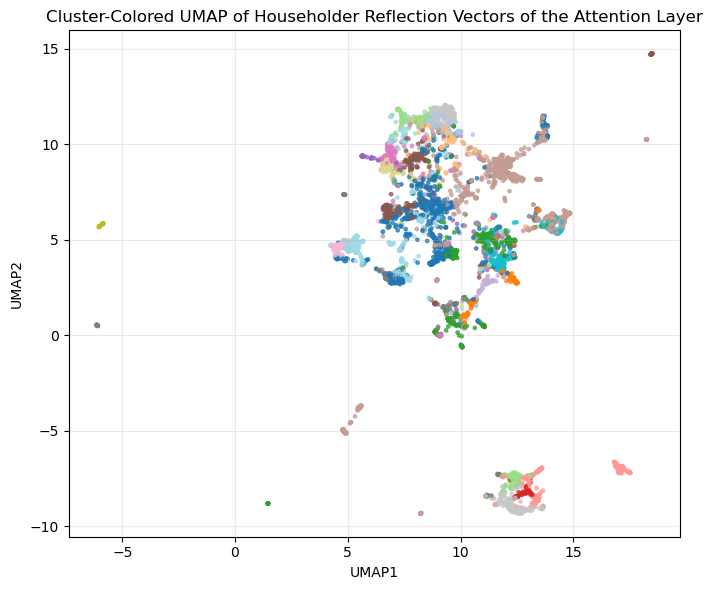

In [37]:
attention_clustered_hh_vecs_X_umap, attention_clustered_hh_vecs_umap = create_vec_scatter_umap(attention_hh_vecs_X_cluster_pca,
                                                                              'Cluster-Colored UMAP of Householder Reflection Vectors of the Attention Layer',
                                                                              'attention_hh_vecs_clustered_umap.png',
                                                                              attention_hh_vecs_color_labels,
                                                                              proj_dir = proj_dir)

##### Cluster Analysis

In [38]:
def cluster_analysis(vec_array, labels, n_clusters):
    mean_cluster_cos_sims = []

    for cluster_id in range(n_clusters):
        cluster_indexes = np.where(labels == cluster_id)[0]
        cluster_vecs = vec_array[cluster_indexes, :]

        mean_cluster_vec = cluster_vecs.mean(axis=0)

        mean_cluster_vec_vals, mean_cluster_vec_item_idxs = torch.topk(torch.from_numpy(mean_cluster_vec), k = 10)

        print('Cluster ID: ', cluster_id)

        # Printing largest contributors to the average cluster Householder vector
        for k in range(mean_cluster_vec_vals.shape[0]):
            print(f'Token ID: {mean_cluster_vec_item_idxs[k]}, Title: {tokenizer.decode([mean_cluster_vec_item_idxs[k].item()])}, Value: {mean_cluster_vec_vals[k]}')

        # Computing the mean cosine similarity between embeddings of the top titles in the average cluster Householder vector
        cluster_cosine_sims = []
        for i in range(mean_cluster_vec_vals.shape[0]):
            id_1 = mean_cluster_vec_item_idxs[i]

            with torch.no_grad():
                embed_1 = embedding_model(torch.tensor([id_1], device = device).unsqueeze(dim = 0), use_pos_embeds = False)
                embed_1 = embed_1.squeeze()

                for j in range(i + 1, mean_cluster_vec_vals.shape[0]):
                    id_2 = mean_cluster_vec_item_idxs[j]

                    embed_2 = embedding_model(torch.tensor([id_2], device = device).unsqueeze(dim = 0), use_pos_embeds = False)
                    embed_2 = embed_2.squeeze()

                    cos_sim = nn.functional.cosine_similarity(embed_1, embed_2, dim = 0)
                    cluster_cosine_sims.append(cos_sim)

        mean_cluster_cosine_sim = sum(cluster_cosine_sims) / len(cluster_cosine_sims)
        mean_cluster_cos_sims.append(mean_cluster_cosine_sim)

        print('\n')
        print(f'Mean Cluster Embedding Cosine Similarity: {mean_cluster_cosine_sim.item():.4f}')
        print('---\n')

    return mean_cluster_cos_sims

In [39]:
# Attention cluster analysis - searching for semantic cohesion in attention clusters
attention_mean_cluster_cos_sims = cluster_analysis(attention_hh_vecs_array,
                                                  attention_hh_vecs_color_labels,
                                                  n_clusters_attention)

Cluster ID:  0
Token ID: 262, Title:  the, Value: 0.01872183009982109
Token ID: 484, Title:  they, Value: 0.004299734719097614
Token ID: 1816, Title:  went, Value: 0.003925401717424393
Token ID: 1690, Title:  often, Value: 0.0014660290908068419
Token ID: 1444, Title:  called, Value: 0.0012626900570467114
Token ID: 3066, Title:  decided, Value: 0.001002078759483993
Token ID: 339, Title:  he, Value: 0.0008677923469804227
Token ID: 996, Title:  though, Value: 0.00085780443623662
Token ID: 3173, Title:  rules, Value: 0.0005261873593553901
Token ID: 1807, Title:  thought, Value: 0.0004351749666966498


Mean Cluster Embedding Cosine Similarity: 0.0869
---

Cluster ID:  1
Token ID: 1995, Title:  mom, Value: 0.0015058310236781836
Token ID: 6512, Title:  bird, Value: 0.0012676481856033206
Token ID: 35982, Title:  Carly, Value: 0.0011341228382661939
Token ID: 24486, Title:  wo, Value: 0.0008432072936557233
Token ID: 805, Title: man, Value: 0.0006942806066945195
Token ID: 724, Title: ull, Value: 

In [40]:
mean_attention_cluster_cos_sim_cohesion = sum(attention_mean_cluster_cos_sims) / len(attention_mean_cluster_cos_sims)
print(f'Mean Attention Cluster Cohesion (via Cosine Similarity between Title Embeddings): {mean_attention_cluster_cos_sim_cohesion.item():.4f}')

Mean Attention Cluster Cohesion (via Cosine Similarity between Title Embeddings): 0.0948


In [41]:
def get_mean_rand_cluster_embedding_sim(layer_hh_vecs, orig_labels, n_clusters, k = 10):
    rand_cluster_cos_sims = []
    rand_labels = np.random.permutation(orig_labels)

    for rand_cluster_id in range(n_clusters):
        rand_idxs = np.where(rand_labels == rand_cluster_id)[0]
        rand_cluster_vecs = layer_hh_vecs[rand_idxs, :]

        mean_cluster_hh_vec = rand_cluster_vecs.mean(axis = 0)
        mean_cluster_hh_vec_vals, mean_cluster_hh_vec_item_idxs = torch.topk(torch.from_numpy(mean_cluster_hh_vec), k = k)

        cluster_cosine_sims = []
        for i in range(mean_cluster_hh_vec_vals.shape[0]):
            id_1 = mean_cluster_hh_vec_item_idxs[i]

            with torch.no_grad():
                embed_1 = embedding_model(torch.tensor([id_1], device = device).unsqueeze(dim = 0), use_pos_embeds = False)
                embed_1 = embed_1.squeeze()

                for j in range(i + 1, mean_cluster_hh_vec_vals.shape[0]):
                    id_2 = mean_cluster_hh_vec_item_idxs[j]

                    embed_2 = embedding_model(torch.tensor([id_2], device = device).unsqueeze(dim = 0), use_pos_embeds = False)
                    embed_2 = embed_2.squeeze()

                    cos_sim = nn.functional.cosine_similarity(embed_1, embed_2, dim = 0)
                    cluster_cosine_sims.append(cos_sim)

        mean_cluster_cosine_sim = sum(cluster_cosine_sims) / len(cluster_cosine_sims)
        rand_cluster_cos_sims.append(mean_cluster_cosine_sim)

    mean_rand_cluster_cos_sim = sum(rand_cluster_cos_sims) / len(rand_cluster_cos_sims)

    return mean_rand_cluster_cos_sim.item()

In [42]:
# Comparing cohesion in Attention clusters against random baseline
mean_attention_rand_cluster_embedding_sim = get_mean_rand_cluster_embedding_sim(attention_hh_vecs_array,
                                                                                attention_hh_vecs_color_labels,
                                                                                n_clusters_attention)

print(f'Random Baseline for Attention Cluster Cohesion: {mean_attention_rand_cluster_embedding_sim:.4f}')

Random Baseline for Attention Cluster Cohesion: 0.0128


In [43]:
def cluster_cohesion_test(test_vecs, test_labels, test_clusters, test_value, n_trials = 100):
    count = 0
    for trial in tqdm(range(n_trials), desc = 'Running permutations'):
        rand_cluster_cohesion = get_mean_rand_cluster_embedding_sim(attention_hh_vecs_array,
                                                                    attention_hh_vecs_color_labels,
                                                                    n_clusters_attention)

        if rand_cluster_cohesion > test_value:
            count += 1

    p_val = (count + 1) / (n_trials + 1) # Plus one-smoothing is used

    return p_val

In [44]:
# Computing P-value of attention hh_vecs cohesion against randomized baseline
attention_hh_vecs_cohesion_p_val = cluster_cohesion_test(attention_hh_vecs_array,
                                                        attention_hh_vecs_color_labels,
                                                        n_clusters_attention,
                                                        mean_attention_cluster_cos_sim_cohesion.item())
print(f'\nAttention Householder Reflection Vectors Cluster Cohesion P-value: {attention_hh_vecs_cohesion_p_val:.4f}')

Running permutations: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Attention Householder Reflection Vectors Cluster Cohesion P-value: 0.0099


#### MLP Layer

In [47]:
pca_dims = 800
mlp_hh_vecs_X_cluster_pca, mlp_hh_vecs_cluster_pca = efficient_pca(mlp_hh_vecs_array,
                                                                    create_scatter = False,
                                                                    method="randomized",
                                                                    n_components = pca_dims)

# Explained variance check
mlp_hh_vecs_ex_var_ratio = mlp_hh_vecs_cluster_pca.explained_variance_ratio_.sum()
print(f'Explained Variance ratio for {pca_dims} dimensions: {(mlp_hh_vecs_ex_var_ratio * 100):.4f}%')

Explained Variance ratio for 800 dimensions: 90.4947%


Starting MiniBatchKMeans fitting for number of clusters between 5 and 150...


Fitting clusters: 100%|██████████| 30/30 [00:18<00:00,  1.64it/s]


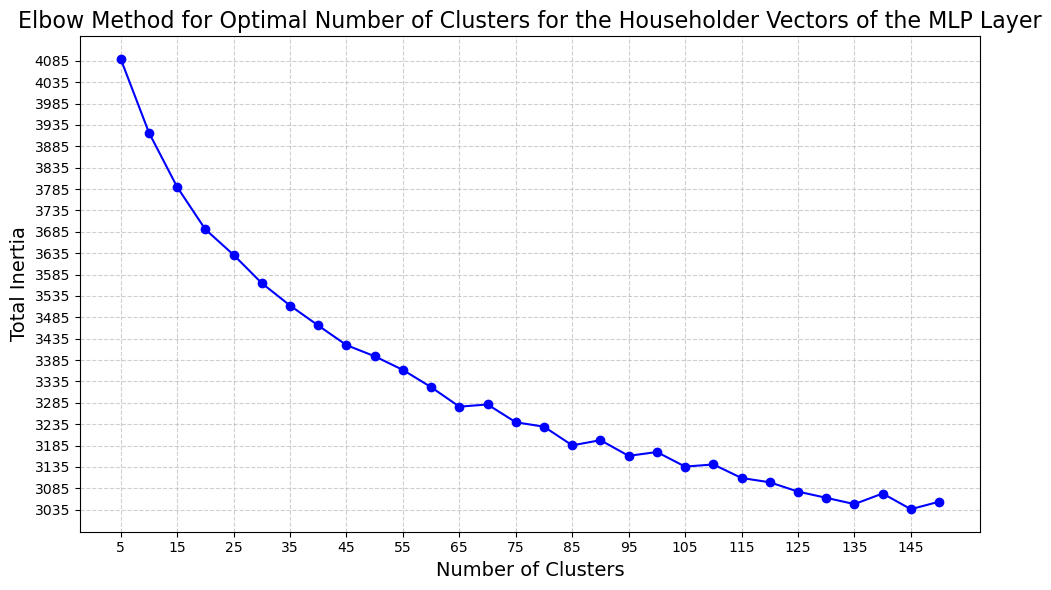

In [48]:
# Creating elbow plot for the Householder Vectors of the Attention Layer
elbow_plot_analysis(mlp_hh_vecs_X_cluster_pca,
                    'Elbow Method for Optimal Number of Clusters for the Householder Vectors of the MLP Layer',
                    'elbow_mlp_hh_vecs.png',
                   5, 150, 5)

In [51]:
mlp_hh_vecs_X_cluster_pca = mlp_hh_vecs_X_cluster_pca.astype('float64')

n_clusters_mlp = 35

# Initializing MiniBatchKMeans
mlp_hh_vecs_kmeans = MiniBatchKMeans(
    n_clusters=n_clusters_mlp,
    random_state=random_state_val,
    n_init='auto',
    max_iter=30,
    verbose=1
)

# Training k-means model
mlp_hh_vecs_kmeans.fit(mlp_hh_vecs_X_cluster_pca)

# Assigning each point to cluster
mlp_hh_vecs_color_labels = mlp_hh_vecs_kmeans.predict(mlp_hh_vecs_X_cluster_pca)

Init 1/1 with method k-means++
Inertia for init 1/1: 3663.5152563372017
Minibatch step 1/146: mean batch inertia: 1.1761083678326618
Minibatch step 2/146: mean batch inertia: 0.7407087201591993, ewa inertia: 0.7407087201591993
Minibatch step 3/146: mean batch inertia: 0.721986484225663, ewa inertia: 0.7330416257397068
Minibatch step 4/146: mean batch inertia: 0.719524664809837, ewa inertia: 0.7275061856308538
Minibatch step 5/146: mean batch inertia: 0.7190386144799575, ewa inertia: 0.7240385620121703
Minibatch step 6/146: mean batch inertia: 0.7150388577305166, ewa inertia: 0.720353020246758
Minibatch step 7/146: mean batch inertia: 0.715392376070377, ewa inertia: 0.7183215466868242
Minibatch step 8/146: mean batch inertia: 0.7145295743067228, ewa inertia: 0.7167686653761968
Minibatch step 9/146: mean batch inertia: 0.7104094923513065, ewa inertia: 0.7141644689444879
Minibatch step 10/146: mean batch inertia: 0.7101498122023722, ewa inertia: 0.7125203943578347
Minibatch step 11/146: m

/mmfs1/gscratch/stf/ipro13/conda_envs/quantum-conda/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


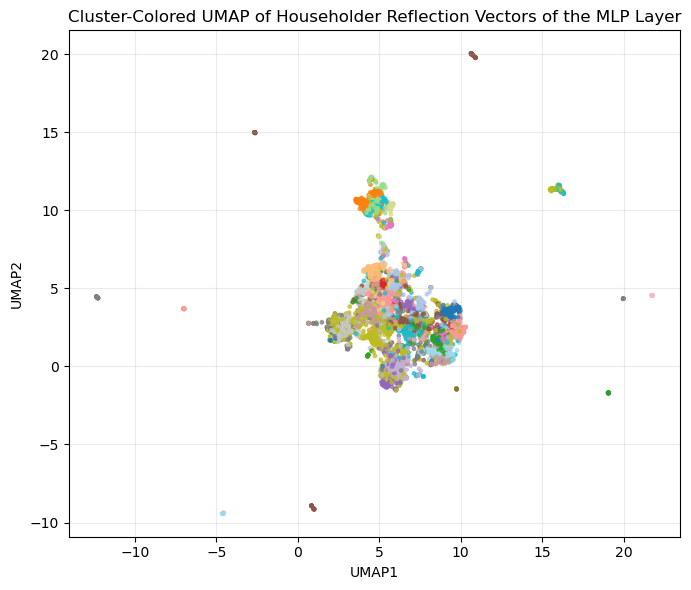

In [52]:
mlp_clustered_hh_vecs_X_umap, mlp_clustered_hh_vecs_umap = create_vec_scatter_umap(mlp_hh_vecs_X_cluster_pca,
                                                                              'Cluster-Colored UMAP of Householder Reflection Vectors of the MLP Layer',
                                                                              'mlp_hh_vecs_clustered_umap.png',
                                                                              mlp_hh_vecs_color_labels,
                                                                              proj_dir = proj_dir)

#### Cluster Cohesion

In [53]:
# MLP cluster analysis - searching for semantic cohesion in MLP clusters
mlp_mean_cluster_cos_sims = cluster_analysis(mlp_hh_vecs_array,
                                            mlp_hh_vecs_color_labels,
                                            n_clusters_mlp)

Cluster ID:  0
Token ID: 6279, Title:  cloud, Value: 0.039788588881492615
Token ID: 15452, Title:  arrow, Value: 0.02842879295349121
Token ID: 11847, Title:  chamber, Value: 0.028311697766184807
Token ID: 19716, Title:  prince, Value: 0.022643040865659714
Token ID: 275, Title:  b, Value: 0.020381201058626175
Token ID: 11, Title: ,, Value: 0.01717095449566841
Token ID: 5509, Title:  tree, Value: 0.015934603288769722
Token ID: 2456, Title:  words, Value: 0.015410738997161388
Token ID: 13701, Title:  vegetables, Value: 0.013746199198067188
Token ID: 25949, Title:  aunt, Value: 0.008682627230882645


Mean Cluster Embedding Cosine Similarity: 0.0458
---

Cluster ID:  1
Token ID: 290, Title:  and, Value: 0.4758055508136749
Token ID: 8196, Title:  scream, Value: 0.002094972413033247
Token ID: 3960, Title:  cry, Value: 0.0012272547464817762
Token ID: 3420, Title:  door, Value: 0.0010908169206231833
Token ID: 10164, Title:  weigh, Value: 0.001077297842130065
Token ID: 3503, Title:  etc, Value: 

In [54]:
mean_mlp_cluster_cos_sim_cohesion = sum(mlp_mean_cluster_cos_sims) / len(mlp_mean_cluster_cos_sims)
print(f'Mean MLP Cluster Cohesion (via Cosine Similarity between Title Embeddings): {mean_mlp_cluster_cos_sim_cohesion.item():.4f}')

Mean MLP Cluster Cohesion (via Cosine Similarity between Title Embeddings): 0.0514


In [55]:
# Comparing semantic cohesion in MLP clusters against random baseline
mean_mlp_rand_cluster_embedding_sim = get_mean_rand_cluster_embedding_sim(mlp_hh_vecs_array,
                                                                          mlp_hh_vecs_color_labels,
                                                                          n_clusters_mlp)

print(f'Random Baseline for MLP Cluster Cohesion: {mean_mlp_rand_cluster_embedding_sim:.4f}')

Random Baseline for MLP Cluster Cohesion: 0.0165


In [56]:
# Computing P-value of attention hh_vecs cohesion against randomized baseline
mlp_hh_vecs_cohesion_p_val = cluster_cohesion_test(mlp_hh_vecs_array,
                                                  mlp_hh_vecs_color_labels,
                                                  n_clusters_mlp,
                                                  mean_mlp_cluster_cos_sim_cohesion.item())
print(f'\nMLP Householder Reflection Vectors Cluster Cohesion P-value: {mlp_hh_vecs_cohesion_p_val:.4f}')

Running permutations: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


MLP Householder Reflection Vectors Cluster Cohesion P-value: 0.0099


## Frobenius Similarities

### Permutation Tests for the Frobenius Similarity of Unitary Operators

In [59]:
'''
mean_from_sim_submatrix() returns the mean pairwise similarity
computed from an input simularity (or Gram) submatrix.

    Args:
        sim_submatrix (torch.Tensor): Square matrix to compute mean similarities from.

    Returns:
        (float): Mean pairwise similarity from the input matrix.
'''
def mean_from_sim_submatrix(sim_submatrix: torch.Tensor) -> float:

    # Shape check
    n = sim_submatrix.shape[0]
    if n < 2:
        return float("nan")

    # Summing unique off-diagonal elements to get all unique pairwise similarities
    # All entries with row < collumn are effectiely summed
    total = sim_submatrix.sum()
    diag = sim_submatrix.diag().sum()
    sum_offdiag = (total - diag) / 2.0

    # Total number of elements
    denom = n * (n - 1) / 2.0

    return (sum_offdiag / denom).item()

'''
permutation_test_precompute() conducts a permutation test to determine the
statistical significance of an observed difference in mean pairwise Frobenius
cosine similarities between unitary operators or Hamiltonians dervided from a
test set of Householder reflection vectors and a random baseline using GPU
(if available).

    Args:
        pooled_numpy (numpy.ndarray): N by d array of test set vectors concatenated
                                      with that of the random baseline.
        n_test (int): Number of test set vectors located at the start of the
                      pooled_numpy array.
        test_unitaries (bool, optional): Whether to conduct test of unitary operators
                                         (True) or Hamiltonians (False), defaults to True.
        device (str, optional): Sets the device to run test on, defaults to 'cuda'.
        n_perms (int, optional): Number of permutations to run in the permutation test,
                                 defaults to 1000.
        two_sided (bool, optional): Whether to conduct a two_sided permutation test,
                                    defaults to True.
        seed (int, optional): Random seed to use, defaults to 42.
        dtype (torch.dtype, optional): Sets dtype used by torch, defaults to torch.float64.
        verbose (bool, optional): If True, prints the observed mean pairwise similarities
                                  from the test vectors and random baseline vectors,
                                  defaults to False.

    Returns:
        obs_diff (float): Observed difference in mean pairwise similarities between
                          the test vectors and the random baseline.
        pval (float): P-value obtained by the conducted permutation test.
'''
def permutation_test_precompute(pooled_numpy, n_test, test_unitaries = True, device='cuda', n_perms=1000,
                                two_sided=True, seed=42, dtype=torch.float64, verbose = False):
    """
    pooled_numpy : (N, d) numpy array
    n_test       : number of samples in group A (first group size)
    """
    rng = np.random.default_rng(seed)
    torch.manual_seed(seed)

    device = torch.device(device)
    pooled = torch.from_numpy(pooled_numpy).to(device=device, dtype=dtype)

    N, d = pooled.shape
    # Computing the Gram matrix of inner products in float32 on GPU
    with torch.no_grad():
        Gram = pooled @ pooled.t()  # Shape: (N, N)

        # Converting Gram matrix to that of frobenius cosine similarities
        denom = float(d)

        if test_unitaries:
            # Unitary-operator-based similarity
            Sim = (1.0 - (4.0 / denom)) + (4.0 / denom) * (Gram * Gram)
        else:
            # Hamiltonian-based similarity
            Sim = (Gram * Gram)

    # Computing the observed difference
    mean_a = mean_from_sim_submatrix(Sim[:n_test, :n_test])
    mean_b = mean_from_sim_submatrix(Sim[n_test:, n_test:])

    obs_diff = mean_a - mean_b

    if verbose:
        # Printing Layer and Baseline Similarities
        print('Mean Frobenius Cosine Similarity for Layer: ', mean_a)
        print('Mean Frobenius Cosine Similarity for Random Baseline: ', mean_b)

    perm_diffs = np.empty(n_perms, dtype=float)
    # Permute indices on CPU but indexing Sim happens on GPU
    for t in range(n_perms):
        perm_idx = rng.permutation(N)
        idx_a = perm_idx[:n_test]
        idx_b = perm_idx[n_test:]

        # Slicing Sim to capture permutated indexes
        sim_a = Sim[idx_a][:, idx_a]
        sim_b = Sim[idx_b][:, idx_b]

        perm_diffs[t] = mean_from_sim_submatrix(sim_a) - mean_from_sim_submatrix(sim_b)

    if two_sided:
        count = np.sum(np.abs(perm_diffs) >= abs(obs_diff))
    else:
        count = np.sum(perm_diffs >= obs_diff)

    pval = (count + 1) / (n_perms + 1) # Plus one smoothing is used

    return obs_diff, pval

In [62]:
def get_random_hh_vecs(dim_vecs, num_vecs):
    phi_0_vecs = np.abs(np.random.randn(num_vecs, dim_vecs))
    phi_0_vecs = phi_0_vecs / np.linalg.norm(phi_0_vecs, axis=1, keepdims=True)

    phi_1_vecs = np.abs(np.random.randn(num_vecs, dim_vecs))
    phi_1_vecs = phi_1_vecs / np.linalg.norm(phi_1_vecs, axis=1, keepdims=True)

    hh_vecs = []
    for i in range(phi_0_vecs.shape[0]):
        hh = phi_1_vecs[i, :] - phi_0_vecs[i, :]
        hh = hh / np.linalg.norm(hh)

        hh_vecs.append(hh)

    hh_vecs = np.asarray(hh_vecs)

    return hh_vecs

In [60]:
if 1000 <= attention_hh_vecs_array.shape[0]:
    n_sample = 1000
else:
    n_sample = attention_hh_vecs_array.shape[0]

print('Sample size:', n_sample)

Sample size: 1000


In [63]:
rand_hh_vecs = get_random_hh_vecs(mlp_hh_vecs_array.shape[1], n_sample)

In [66]:
# Sampling from attention and embedding layer householder vector arrays
rand_sample_idxs = random.sample(range(attention_hh_vecs_array.shape[0]), n_sample)

attention_hh_vecs_array_sample = attention_hh_vecs_array[rand_sample_idxs, :]
mlp_hh_vecs_array_sample = mlp_hh_vecs_array[rand_sample_idxs, :]

In [70]:
atten_diff, atten_pval = permutation_test_precompute(np.concatenate((attention_hh_vecs_array_sample, rand_hh_vecs), axis = 0),
                                                     n_test = n_sample,
                                                     test_unitaries = True,
                                                     verbose = True)

Mean Frobenius Cosine Similarity for Layer:  0.9999215984790245
Mean Frobenius Cosine Similarity for Random Baseline:  0.9999204122666081


In [71]:
print(f'Attention Observed Difference: {atten_diff}\nAttention P-value: {atten_pval}')

Attention Observed Difference: 1.1862124164041532e-06
Attention P-value: 0.000999000999000999


In [72]:
mlp_diff, mlp_pval = permutation_test_precompute(np.concatenate((mlp_hh_vecs_array_sample, rand_hh_vecs), axis = 0),
                                                 n_test = n_sample,
                                                 test_unitaries = True,
                                                 verbose = True)

Mean Frobenius Cosine Similarity for Layer:  0.9999212321636136
Mean Frobenius Cosine Similarity for Random Baseline:  0.9999204122666081


In [73]:
print(f'MLP Observed Difference: {mlp_diff}\nMLP P-value: {mlp_pval}')

MLP Observed Difference: 8.198970055106614e-07
MLP P-value: 0.000999000999000999


### Computing the Frobenius Similarity of Hamiltonians

In [74]:
atten_hamiltonian_diff, atten_hamiltonian_pval = permutation_test_precompute(np.concatenate((attention_hh_vecs_array_sample, rand_hh_vecs), axis = 0),
                                                                            n_test = n_sample,
                                                                            test_unitaries = False,
                                                                            verbose = True)

Mean Frobenius Cosine Similarity for Layer:  0.014924089704255352
Mean Frobenius Cosine Similarity for Random Baseline:  1.9923798443608995e-05


In [75]:
print(f'Attention Observed Difference for Hamiltonians: {atten_hamiltonian_diff}\nAttention P-value for Hamiltonians: {atten_hamiltonian_pval}')

Attention Observed Difference for Hamiltonians: 0.014904165905811742
Attention P-value for Hamiltonians: 0.000999000999000999


In [76]:
mlp_hamiltonian_diff, mlp_hamiltonian_pval = permutation_test_precompute(np.concatenate((mlp_hh_vecs_array_sample, rand_hh_vecs), axis = 0),
                                                                        n_test = n_sample,
                                                                        test_unitaries = False,
                                                                        verbose = True)

Mean Frobenius Cosine Similarity for Layer:  0.010321519723884284
Mean Frobenius Cosine Similarity for Random Baseline:  1.9923798443608995e-05


In [77]:
print(f'MLP Observed Difference for Hamiltonians: {mlp_hamiltonian_diff}\nMLP P-value for Hamiltonians: {mlp_hamiltonian_pval}')

MLP Observed Difference for Hamiltonians: 0.010301595925440674
MLP P-value for Hamiltonians: 0.000999000999000999


## Analyzing Interdependence

In [78]:
dcor_interdependence = dcor.distance_correlation(attention_hh_vecs_array_sample, mlp_hh_vecs_array_sample)
print(f'Distance correlation between Attention and MLP layer Householder vectors: {dcor_interdependence:.6f}')

Distance correlation between Attention and MLP layer Householder vectors: 0.598964


In [79]:
dcor_t_test = dcor.independence.distance_correlation_t_test(attention_hh_vecs_array_sample, mlp_hh_vecs_array_sample)
print(f'Distance correlation t-test for independence P Value: {dcor_t_test.pvalue:.6f}')

Distance correlation t-test for independence P Value: 0.000000


In [80]:
dcor_covar_test = dcor.independence.distance_covariance_test(attention_hh_vecs_array_sample,
                                                          mlp_hh_vecs_array_sample,
                                                          num_resamples=1000,
                                                          random_state=42,
                                                        )
print(f'Distance correlation Covariance test for independence P Value: {dcor_covar_test.pvalue:.6f}')

Distance correlation Covariance test for independence P Value: 0.000999


## Analyzing Changes in State Vectors Derived from Hamiltonians

In [81]:
'''
get_last_inst_delta_phis() computes change in model state vectors over a layer using
the properties of its Hamiltonian

Args:
    phi0_array (2D np.ndarray): Array of input state vectors
    hh_vecs_array (2D np.ndarray): Array of Householder reflection vectors
                                   defining the layer Hamiltonian
    alpha (float, optional): Constant to correct for scaled definition of
                             the original Hamiltonian, defaults to 1.
Returns:
    delta_phi_array (2D np.ndarray): Array of change in model state vectors
'''
def get_last_inst_delta_phis(phi0_array, hh_vecs_array, alpha = 1):

  # First dimension (S): number of sequences
  # Second dimension (V): model vocabulary size
  S, V = phi0_array.shape

  delta_phi_array = np.zeros(phi0_array.shape)

  # Looping over all sequences
  for i in range(S):
      hh_vec = hh_vecs_array[i, :]
      phi0 = phi0_array[i, :]

      # Hamiltonian is constructed with hh_vec as an eigenvector with eigenvalue pi
      eigenvalue = np.pi

      # Preparing eigenvalue_scale_factor for delta phi computation
      eigenvalue_scale_factor = (cmath.exp(1j * alpha * eigenvalue) - 1)
      eigenvalue_scale_factor = complex(round(eigenvalue_scale_factor.real, 3), round(eigenvalue_scale_factor.imag, 3))
      if eigenvalue_scale_factor.imag == 0:
          eigenvalue_scale_factor = eigenvalue_scale_factor.real

      delta_phi = eigenvalue_scale_factor * hh_vec * np.dot(hh_vec, phi0)

      delta_phi_array[i, :] = delta_phi

  return delta_phi_array

In [82]:
# Preparing attention_ket0_vecs and attention_hh_vecs as numpy arrays
attention_ket0_vecs = np.array(attention_ket0_vecs).squeeze(axis = 1)
attention_hh_vecs = np.array(attention_hh_vecs).squeeze(axis = 1)

In [83]:
attention_delta_phis = get_last_inst_delta_phis(attention_ket0_vecs, attention_hh_vecs)

In [84]:
# Preparing mlp_ket0_vecs and mlp_hh_vecs as numpy arrays
mlp_ket0_vecs = np.array(mlp_ket0_vecs).squeeze(axis = 1)
mlp_hh_vecs = np.array(mlp_hh_vecs).squeeze(axis = 1)

In [85]:
mlp_delta_phis = get_last_inst_delta_phis(mlp_ket0_vecs, mlp_hh_vecs)

In [86]:
ave_attention_delta_phi = np.mean(attention_delta_phis, axis = 0)

print(f'Average Attention Delta Phi L2 Norm: {np.linalg.norm(ave_attention_delta_phi)}')

Average Attention Delta Phi L2 Norm: 0.17480661231576033


In [87]:
ave_attention_delta_phi_vals, ave_attention_delta_idxs = torch.topk(torch.from_numpy(ave_attention_delta_phi), k = 10)

# Printing largest contributors to the average delta phi vector
for k in range(ave_attention_delta_phi_vals.shape[0]):
    print(f'ID: {ave_attention_delta_idxs[k]}, Token: {tokenizer.decode([ave_attention_delta_idxs[k].item()])}, Value: {ave_attention_delta_phi_vals[k]}')

ID: 16682, Token: urry, Value: 3.7217822822235294e-05
ID: 11395, Token: Value, Value: 2.0019885199537767e-05
ID: 12915, Token: End, Value: 1.9711531746871725e-05
ID: 30707, Token:  Thinking, Value: 1.2615925895574009e-05
ID: 23302, Token:  Above, Value: 5.862127034005127e-06
ID: 6201, Token: aze, Value: 3.2437783845512767e-06
ID: 171, Token: �, Value: 2.2051953492358225e-06
ID: 13356, Token:  invested, Value: 1.319513443761e-06
ID: 12433, Token:  recalled, Value: -1.4930572040846357e-06
ID: 19609, Token:  mesh, Value: -4.037839562479917e-06


In [88]:
ave_mlp_delta_phi = np.mean(mlp_delta_phis, axis = 0)

print(f'Average MLP Delta Phi L2 Norm: {np.linalg.norm(ave_mlp_delta_phi)}')

Average MLP Delta Phi L2 Norm: 0.08369879187965884


In [89]:
ave_mlp_delta_phi_vals, ave_mlp_delta_idxs = torch.topk(torch.from_numpy(ave_mlp_delta_phi), k = 10)

# Printing largest contributors to the average delta phi vector
for k in range(ave_mlp_delta_phi_vals.shape[0]):
    print(f'ID: {ave_mlp_delta_idxs[k]}, Token: {tokenizer.decode([ave_mlp_delta_idxs[k].item()])}, Component Value: {ave_mlp_delta_phi_vals[k]}')

ID: 38576, Token: Rh, Component Value: 0.00012939213470755087
ID: 2118, Token: rest, Component Value: 0.00012600930289157416
ID: 27761, Token: cards, Component Value: 0.00010176795958711913
ID: 20963, Token: bee, Component Value: 8.0856226003413e-05
ID: 7149, Token: Any, Component Value: 7.382077231037774e-05
ID: 34568, Token:  stained, Component Value: 7.047903695965703e-05
ID: 46380, Token:  Tooth, Component Value: 5.3755995082627716e-05
ID: 12915, Token: End, Component Value: 5.225488950284881e-05
ID: 43227, Token: Anne, Component Value: 5.080895350979846e-05
ID: 26744, Token:  instincts, Component Value: 3.920974449118052e-05


### Permutation Tests for the Statistical Significance of the Delta Phi Magnitude

In [90]:
'''
get_random_ket_vecs() randomly generates valid state vector kets through a process
similar to that used to derive the state vectors using Tuned Lenses

Args:
    dim_vecs (int): Dimensionality of random kets to generate
    num_vecs (int): Number of random kets to generate

Returns:
    phi_0_vecs (np.ndarray): 2D array of random kets
'''
def get_random_ket_vecs(dim_vecs, num_vecs):
    phi_0_vecs = np.abs(np.random.randn(num_vecs, dim_vecs))
    phi_0_vecs = phi_0_vecs / np.linalg.norm(phi_0_vecs, axis=1, keepdims=True)

    return phi_0_vecs

'''
get_mean_delta_phi_norm() computes the magnitude of the mean vector
of the inputted 2D array of vectors

Args:
    vecs (np.ndarray): 2D array of input vectors

Returns:
    ave_vec_norm (float): Magnitude (L2 norm) of the mean vector
'''
def get_mean_vec_norm(vecs):
    ave_vec = np.mean(vecs, axis = 0)
    ave_vec_norm = np.linalg.norm(ave_vec)

    return ave_vec_norm

'''
delta_phi_norm_permutation_test() conducts a permutation test to determine the
statistical significance of the magnitude of the average input delta phi vectors
against a random baseline

Args:
    input_delta_phis (np.ndarray): 2D array of input delta phi vectors
    n_perms (int, optional): Number of permutations to run, defaults to 1000
    two_sided (bool, optional): Whether to run a two sided permutation test,
                                defaults to True
    seed (int, optional): Random seed to use, defaults to 42
    verbose (bool, optional): If True, prints the magnitude for the mean delta
                              phi vectors inputted and that for the randomized
                              baseline; defaults to False

Returns:
    obs_diff (float): Observed difference in the permutation test
    p_value (float): P-value obtained by the permutation test
'''
def delta_phi_norm_permutation_test(input_delta_phis, n_perms=1000,
                                two_sided=True, seed=42, verbose = False):
    # Initializing RNG object
    rng = np.random.default_rng(seed)

    num_vecs = input_delta_phis.shape[0]
    dim_vecs = input_delta_phis.shape[1]

    # Obtaining Random Kets, Householder, and Delta Phi Vectors
    rand_ket0_vecs = get_random_hh_vecs(dim_vecs, num_vecs)
    rand_hh_vecs = get_random_hh_vecs(dim_vecs, num_vecs)
    rand_delta_phi_vecs = get_last_inst_delta_phis(rand_ket0_vecs, rand_hh_vecs)

    # Creating pooled array
    pooled = np.concatenate((input_delta_phis, rand_delta_phi_vecs), axis = 0)
    N, d = pooled.shape

    # Computing the observed difference
    mean_a = get_mean_vec_norm(pooled[:num_vecs, :])
    mean_b = get_mean_vec_norm(pooled[num_vecs:, :])

    if verbose:
        print('Mean Delta Phi Magnitude for Layer: ', mean_a)
        print('Mean Delta Phi Magnitude for Random Baseline: ', mean_b)

    # Computing observed difference
    obs_diff = mean_a - mean_b

    # Running permutations
    perm_diffs = np.empty(n_perms, dtype=float)
    for t in tqdm(range(n_perms), desc = 'Running Permuations'):
        perm_idx = rng.permutation(N)
        idx_a = perm_idx[:num_vecs]
        idx_b = perm_idx[num_vecs:]

        # Finding permutated norms
        norm_a = get_mean_vec_norm(pooled[idx_a, :])
        norm_b = get_mean_vec_norm(pooled[idx_b, :])

        perm_diffs[t] = norm_a - norm_b

    if two_sided:
        count = np.sum(np.abs(perm_diffs) >= abs(obs_diff))
    else:
        count = np.sum(perm_diffs >= obs_diff)

    pval = (count + 1) / (n_perms + 1) # Plus one smooting is used

    return obs_diff, pval

In [93]:
attention_delta_phi_norm_diff, attention_delta_phi_norm_p_val = delta_phi_norm_permutation_test(attention_delta_phis,
                                                                                                n_perms = 100,
                                                                                                two_sided = False,
                                                                                                verbose = True)

Mean Delta Phi Magnitude for Layer:  0.17480661231576033
Mean Delta Phi Magnitude for Random Baseline:  0.0001270576376095623


Running Permuations: 100%|██████████| 100/100 [02:23<00:00,  1.44s/it]


In [94]:
print(f'Attention Delta Phi Magnitude Observed Difference: {attention_delta_phi_norm_diff:.6f}\nAttention Delta Phi Magnitude P-value: {attention_delta_phi_norm_p_val:.6f}')

Attention Delta Phi Magnitude Observed Difference: 0.174680
Attention Delta Phi Magnitude P-value: 0.009901


In [96]:
mlp_delta_phi_norm_diff, mlp_delta_phi_norm_p_val = delta_phi_norm_permutation_test(mlp_delta_phis,
                                                                                    n_perms = 100,
                                                                                    two_sided = False,
                                                                                    verbose = True)

Mean Delta Phi Magnitude for Layer:  0.08369879187965884
Mean Delta Phi Magnitude for Random Baseline:  0.00012700684010050802


Running Permuations: 100%|██████████| 100/100 [02:22<00:00,  1.42s/it]


In [97]:
print(f'MLP Delta Phi Magnitude Observed Difference: {mlp_delta_phi_norm_diff:.6f}\nMLP Delta Phi Magnitude P-value: {mlp_delta_phi_norm_p_val:.6f}')

MLP Delta Phi Magnitude Observed Difference: 0.083572
MLP Delta Phi Magnitude P-value: 0.009901


### PCA Plot of Delta Phi Vectors

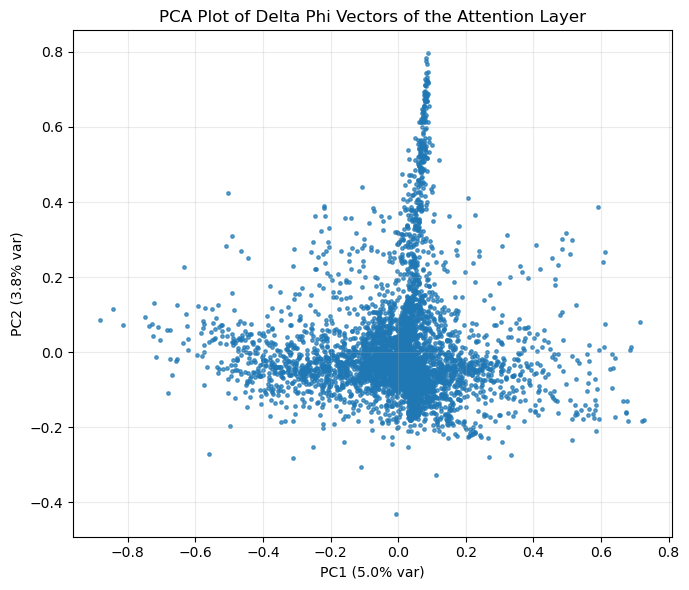

In [98]:
attention_delta_phi_X_pca, attention_delta_phi_pca = efficient_pca(attention_delta_phis,
                                                                            'PCA Plot of Delta Phi Vectors of the Attention Layer',
                                                                            'attention_delta_phi_vecs_pca.png',
                                                                            proj_dir=proj_dir,
                                                                            method="randomized")

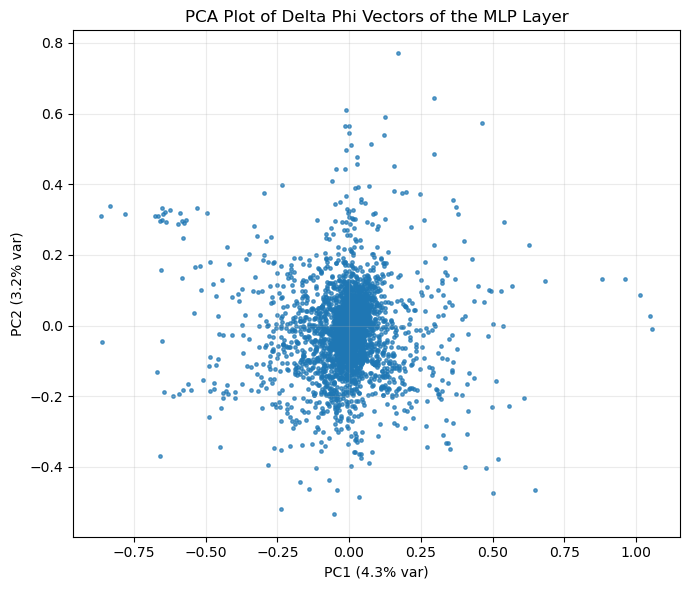

In [99]:
mlp_delta_phi_X_pca, mlp_delta_phi_pca = efficient_pca(mlp_delta_phis,
                                                                'PCA Plot of Delta Phi Vectors of the MLP Layer',
                                                                'mlp_delta_phi_vecs_pca.png',
                                                                proj_dir=proj_dir,
                                                                method="randomized")

### Clustering and UMAP of Delta Phi Vectors

#### Attention Layer

In [100]:
attention_delta_phi_pca_dims = 600
attention_delta_phi_X_cluster_pca, attention_delta_phi_cluster_pca = efficient_pca(attention_delta_phis,
                                                                    create_scatter = False,
                                                                    method="randomized",
                                                                    n_components = attention_delta_phi_pca_dims)

# Explained variance check
attention_ex_var_ratio = attention_delta_phi_cluster_pca.explained_variance_ratio_.sum()
print(f'Explained Variance ratio for {attention_delta_phi_pca_dims} dimensions: {(attention_ex_var_ratio * 100):.4f}%')

Explained Variance ratio for 600 dimensions: 91.0121%


Starting MiniBatchKMeans fitting for number of clusters between 5 and 150...


Fitting clusters: 100%|██████████| 30/30 [00:14<00:00,  2.04it/s]


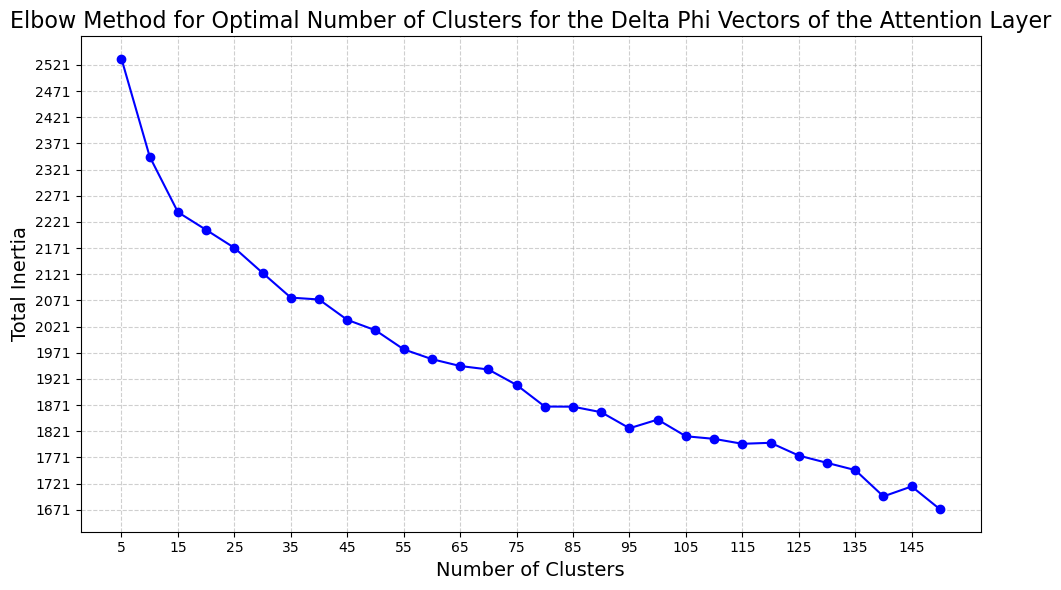

In [101]:
# Creating elbow plot for the Delta Phi Vectors of the Attention Layer
elbow_plot_analysis(attention_delta_phi_X_cluster_pca,
                    'Elbow Method for Optimal Number of Clusters for the Delta Phi Vectors of the Attention Layer',
                    'elbow_attention_delta_phi_vecs.png',
                    5, 150, 5)

In [102]:
# Clustering delta phi vectors

attention_delta_phi_X_cluster_pca = attention_delta_phi_X_cluster_pca.astype('float64')

n_clusters = 35
random_state_val = 42

# Initializing MiniBatchKMeans
attention_delta_phi_kmeans = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=random_state_val,
    n_init='auto',
    max_iter=30,
    verbose=1
)

# Training k-means model
attention_delta_phi_kmeans.fit(attention_delta_phi_X_cluster_pca)

# Assigning each point to cluster
attention_delta_phi_color_labels = attention_delta_phi_kmeans.predict(attention_delta_phi_X_cluster_pca)

Init 1/1 with method k-means++
Inertia for init 1/1: 1631.2861601837214
[MiniBatchKMeans] Reassigning 22 cluster centers.
Minibatch step 1/146: mean batch inertia: 0.49976598710370485
[MiniBatchKMeans] Reassigning 14 cluster centers.
Minibatch step 2/146: mean batch inertia: 0.4821701083295478, ewa inertia: 0.4821701083295478
[MiniBatchKMeans] Reassigning 11 cluster centers.
Minibatch step 3/146: mean batch inertia: 0.44906399642838907, ewa inertia: 0.46861255640521804
[MiniBatchKMeans] Reassigning 10 cluster centers.
Minibatch step 4/146: mean batch inertia: 0.45559516005394207, ewa inertia: 0.4632816970316101
[MiniBatchKMeans] Reassigning 3 cluster centers.
Minibatch step 5/146: mean batch inertia: 0.4457599001368921, ewa inertia: 0.45610620412211544
[MiniBatchKMeans] Reassigning 5 cluster centers.
Minibatch step 6/146: mean batch inertia: 0.4372791868945183, ewa inertia: 0.4483961998665427
[MiniBatchKMeans] Reassigning 4 cluster centers.
Minibatch step 7/146: mean batch inertia: 0.4

/mmfs1/gscratch/stf/ipro13/conda_envs/quantum-conda/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


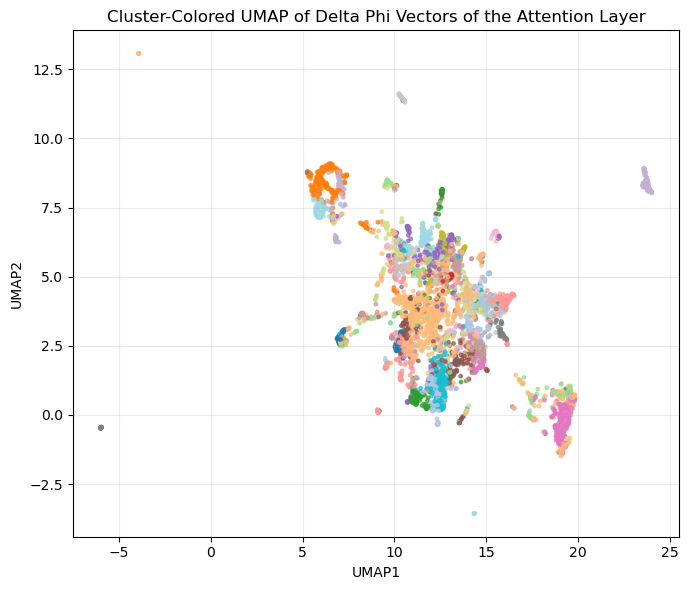

In [103]:
attention_clustered_delta_phi_X_umap, attention_clustered_delta_phi_umap = create_vec_scatter_umap(attention_delta_phi_X_cluster_pca,
                                                                              'Cluster-Colored UMAP of Delta Phi Vectors of the Attention Layer',
                                                                              'attention_delta_phi_vecs_clustered_umap.png',
                                                                              attention_delta_phi_color_labels,
                                                                              proj_dir = proj_dir)

#### MLP Layer

In [105]:
mlp_delta_phi_pca_dims = 700
mlp_delta_phi_X_cluster_pca, mlp_delta_phi_cluster_pca = efficient_pca(mlp_delta_phis,
                                                                    create_scatter = False,
                                                                    method="randomized",
                                                                    n_components = mlp_delta_phi_pca_dims)

# Explained variance check
mlp_ex_var_ratio = mlp_delta_phi_cluster_pca.explained_variance_ratio_.sum()
print(f'Explained Variance ratio for {mlp_delta_phi_pca_dims} dimensions: {(mlp_ex_var_ratio * 100):.4f}%')

Explained Variance ratio for 700 dimensions: 90.6864%


Starting MiniBatchKMeans fitting for number of clusters between 5 and 150...


Fitting clusters: 100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


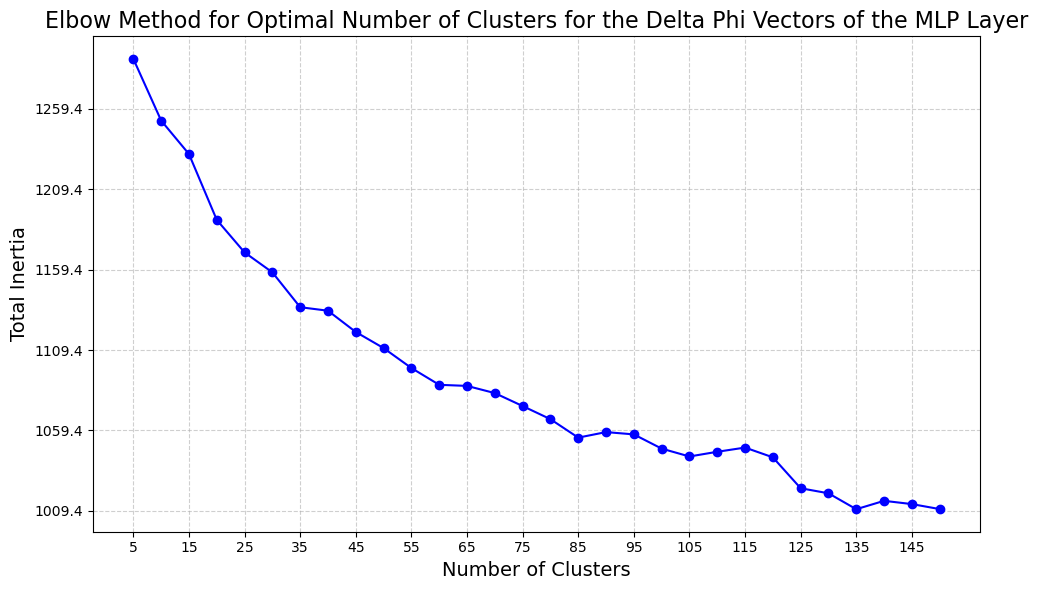

In [106]:
# Creating elbow plot for the Delta Phi Vectors of the Attention Layer
elbow_plot_analysis(mlp_delta_phi_X_cluster_pca,
                    'Elbow Method for Optimal Number of Clusters for the Delta Phi Vectors of the MLP Layer',
                    'elbow_mlp_delta_phi_vecs.png',
                    5, 150, 5)

In [107]:
# Clustering delta phi vectors

mlp_delta_phi_X_cluster_pca = mlp_delta_phi_X_cluster_pca.astype('float64')

n_clusters = 35
random_state_val = 42

# Initializing MiniBatchKMeans
mlp_delta_phi_kmeans = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=random_state_val,
    n_init='auto',
    max_iter=30,
    verbose=1
)

# Training k-means model
mlp_delta_phi_kmeans.fit(mlp_delta_phi_X_cluster_pca)

# Assigning each point to cluster
mlp_delta_phi_color_labels = mlp_delta_phi_kmeans.predict(mlp_delta_phi_X_cluster_pca)

Init 1/1 with method k-means++
Inertia for init 1/1: 791.539999998156
[MiniBatchKMeans] Reassigning 25 cluster centers.
Minibatch step 1/146: mean batch inertia: 0.25838246048421226
[MiniBatchKMeans] Reassigning 12 cluster centers.
Minibatch step 2/146: mean batch inertia: 0.25197565031682806, ewa inertia: 0.25197565031682806
[MiniBatchKMeans] Reassigning 6 cluster centers.
Minibatch step 3/146: mean batch inertia: 0.24590638834836911, ewa inertia: 0.24949017770906884
[MiniBatchKMeans] Reassigning 5 cluster centers.
Minibatch step 4/146: mean batch inertia: 0.25892785437348137, ewa inertia: 0.25335507709093585
[MiniBatchKMeans] Reassigning 4 cluster centers.
Minibatch step 5/146: mean batch inertia: 0.23741590032956428, ewa inertia: 0.24682769576574307
[MiniBatchKMeans] Reassigning 1 cluster centers.
Minibatch step 6/146: mean batch inertia: 0.23707840662954976, ewa inertia: 0.2428351854376239
[MiniBatchKMeans] Reassigning 3 cluster centers.
Minibatch step 7/146: mean batch inertia: 0.

/mmfs1/gscratch/stf/ipro13/conda_envs/quantum-conda/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


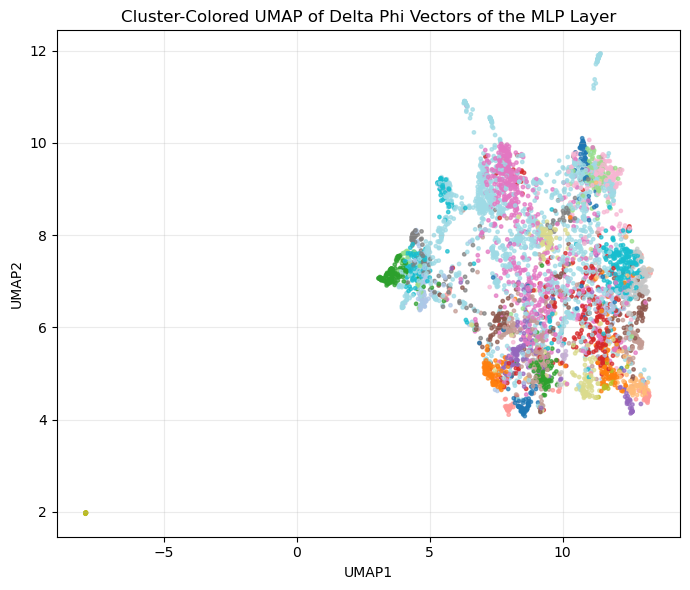

In [108]:
mlp_clustered_delta_phi_X_umap, mlp_clustered_delta_phi_umap = create_vec_scatter_umap(mlp_delta_phi_X_cluster_pca,
                                                                              'Cluster-Colored UMAP of Delta Phi Vectors of the MLP Layer',
                                                                              'mlp_delta_phi_vecs_clustered_umap.png',
                                                                              mlp_delta_phi_color_labels,
                                                                              proj_dir = proj_dir)